<a href="https://colab.research.google.com/github/quentin-duflot/Python_Data_Scientist_Projet/blob/master/Gestion_de_portefeuille.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet d'informatique**




* **Visée du projet**

Notre projet a pour sujet les principales méthodes de trading que l'on retrouve dans le monde de la finance. Nous avons tout d'abord mis en place différentes stratégies automatiques de trading en ayant recours à de réels indicateurs boursiers. Ce travail nous a permis de découvrir et de nous familiariser avec ces indicateurs statistiques utilisés pour donner du sens aux cours des actions. 

Par la suite, nous avons incorporé des technniques de machine learning pour utiliser ces indicateurs simultanément et leur accorder un poids plus ou moins grand dans la prise de décision, à savoir l'achat, la vente, ou le maintien de la position. Ainsi, notre projet s’appuie sur les principales actions tradées en bourse, c’est-à-dire celles du CAC40, pour construire un modèle de prédiction de la bonne décision d'achat ou de vente d'une action en se basant sur différents indicateurs comme le RSI, le MACD ou le stochastique.

* **Rendre le problème réel**

Nous souhaitions que notre algorithme représente la réalité le plus fidèlement possible en reproduisant certaines conditions de trading. Nous considérons d’abord un budget limité pour simuler la stratégie d’un particulier qui investit en bourse. Nous avons ensuite décidé d’étudier le cours des actions depuis 2015 jusqu’à aujourd’hui : ce cours n’est plus faussé par la crise de 2008, mais nous remarquons néanmoins les conséquences de l’épidémie de Covid-19 qui a induit une forte baisse du cours des actions depuis février 2020. Nous avons aussi pris en compte les dividendes rajoutés au portefeuille et les entreprises qui rajoutent des actions sur le marché. Ces deux problèmes peuvent modifier le cours des actions, et donc modifier le profit réalisé tel qu’il est calculé. 

* **Le principal défi : la préparation des données**

Dans un premier temps, notre programme calcule différents indicateurs statistiques d’une action (moyennes mobiles, MACD, le Stochastique …). Ensuite, nous définissons des stratégies qui utilisent le futur de l’action pour déterminer les dates auxquelles le particulier aurait du acheter, conserver ou vendre une action afin de maximiser son profit. 
Le principal défi de notre programme est alors de parvenir à prédire la bonne décision d’un particulier pour n’importe quelle action. Plus singulièrement, nous voulons éviter de faire des modèles de régression sur une action dont le cours est différent de celui des actions qui ont permis d'entrainer le modèle. Par exemple, si les données d’entrainement d’un modèle sont des actions d’institutions financières comme BNP Paribas, le Crédit Agricole ou la Société Générale, il se peut que notre programme ne préside pas les bonnes décisions pour une action d’une entreprise comme Michelin. Afin d’éviter l’overfitting de notre modèle, nous avons classé les actions du CAC40 en plusieurs familles d’actions de cours similaires. En d’autres termes, nous avons trié les actions du CAC40 pour créer plusieurs familles d’actions similaires selon leurs cours. Nous avons alors constitué plusieurs bases de features des indicateurs selon les différentes familles d’actions. Notre algorithme construit alors une fonction qui détermine la classe d’une action et qui prédit ensuite les bonnes décisions d’achat ou de vente selon la date.

# Pré requis 

## Importations des modules

In [72]:
pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

  Using cached https://github.com/matplotlib/mpl_finance/archive/master.zip
  Created wheel for mpl-finance: filename=mpl_finance-0.10.1-cp36-none-any.whl size=8424 sha256=2a327086882042baa7cc5c5801e0c23bb5fd90277b63b4d672a37e18981bf4b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-dpgm9bbf/wheels/8f/bf/8a/6c858b2a3be945c7b2d658fbf6ab797b451d686cbee8aa2679
Successfully built mpl-finance


In [73]:
!pip install pandas_datareader
!pip install matplotlib
!pip install google

In [74]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr   
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.dates import date2num
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from mpl_finance import candlestick_ohlc
import pylab

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## Définition des limites de temps : 

In [75]:
start = datetime.date(2015,1,1)
end = datetime.date.today()
end3 = datetime.datetime(2018,12,20)

pylab.rcParams['figure.figsize'] = (15, 9) #taille des graphiques

## Téléchargement des données du cac 40

In [76]:
symbol_cac40={"lvmh":'MC.PA', "danone": 'BN.PA',"thales": 'HO.PA',"airbus": 'AIR.PA',"total": 'FP.PA',"veolia": 'VIE.PA',\
              "societegenerale": 'GLE.PA',"vinci": 'DG.PA',"peugeot": 'UG.PA',"capgemini": 'CAP.PA',"axa": 'CS.PA',"safran": 'SAF.PA',\
              "Airliquide": 'AI.PA',"carrefour": 'CA.PA',"orange": 'ORA.PA',"accor": 'AC.PA',"bouygues": 'EN.PA',"worldline": 'WLN.PA',\
              "kering": 'KER.PA',"engie": 'ENGI.PA',"BNP": 'BNP.PA',"creditagricole": 'ACA.PA',"sanofi": 'SAN.PA',"pernodricard": "RI.PA",\
              "schneiderelectric": 'SU.PA',"l_oreal": 'OR.PA',"michelin": 'ML.PA',"vivendi": 'VIV.PA',"atos": 'ATO.PA',"sodexo": 'SW.PA',\
              "legrand": 'LR.PA',"saintgobain": 'SGO.PA',"arcelormittal": 'MT.AS',"dassault": 'DSY.PA',"essilorluxottica": 'EL.PA',\
              "hermes": 'RMS.PA',"publicis": 'PUB.PA',"technipfmc": 'FTI.PA',"unibail": 'URW.AS',"renault": 'RNO.PA',"stmicroelectronics": 'STM.PA'}

name_cac40 = ["lvmh", "danone","thales","airbus","total","veolia","societegenerale","vinci","peugeot","capgemini","axa","safran","Airliquide",\
              "carrefour","orange","accor","bouygues","worldline","kering","engie","BNP","creditagricole","sanofi","pernodricard",\
              "schneiderelectric","l_oreal","michelin","vivendi","atos","sodexo","legrand","saintgobain","arcelormittal","dassault",\
              "essilorluxottica","hermes","publicis","technipfmc","unibail","renault","stmicroelectronics"]

cac40 = pdr.get_data_yahoo("^FCHI", start, end)
data_cac40 = {}

for x in name_cac40 : 
    data_cac40[x] = pdr.get_data_yahoo(symbol_cac40[x],start=start, end=end)


In [77]:
data_cac40.keys()

dict_keys(['lvmh', 'danone', 'thales', 'airbus', 'total', 'veolia', 'societegenerale', 'vinci', 'peugeot', 'capgemini', 'axa', 'safran', 'Airliquide', 'carrefour', 'orange', 'accor', 'bouygues', 'worldline', 'kering', 'engie', 'BNP', 'creditagricole', 'sanofi', 'pernodricard', 'schneiderelectric', 'l_oreal', 'michelin', 'vivendi', 'atos', 'sodexo', 'legrand', 'saintgobain', 'arcelormittal', 'dassault', 'essilorluxottica', 'hermes', 'publicis', 'technipfmc', 'unibail', 'renault', 'stmicroelectronics'])

## Diagramme à bougie

La fonction suivante nous permet de représenter les données brutes dans un diagramme à bougie. 

In [78]:
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader \
    from "yahoo"
    :param dat: un DataFrame de pandas avec une date type datetime64 et les colonnes de floats suivantes : "Open", "High", "Low", and "Close", \
    le plus souvent créées à partir du datareader de "yahoo"

    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", \
    "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param stick: une chaine de caractères ou un nombre pour la période de temps couverte par une seule bougie. Les seules chaines de caractères \
    possibles sont  "day", "week", "month", et "year", ("day" par défault), et tous les autres floats qui indiquent le nombre de trades dans la \
    période.

    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
    :param otherseries: un itérable de type liste qui contient les colonnes de dat pour les autres séries à plotter en lignes

    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    
    Sort un graphique en bougie pour les dates stockées dans dat. 
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12

    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365

    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))

    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')


    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)

    ax.grid(True)

    # Création du graphique en chandelier
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)

    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)

    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()

In [79]:
def candlestick(ticker, start, end):
    
    df_ohlc = pdr.get_data_yahoo(ticker, start, end)[['Open','High','Low','Close']]
    df_ohlc.reset_index(inplace=True)

    fig = go.Figure(data=[go.Candlestick(x=df_ohlc['Date'],
                    open=df_ohlc['Open'],
                    high=df_ohlc['High'],
                    low=df_ohlc['Low'],
                    close=df_ohlc['Close'])])
    fig.show()

In [80]:
candlestick('BNP.PA', start, end)

Dans un graphique à bougie : une bougie noire (ou verte) représente un jour où le prix de fermeture était plus haut que le prix d'ouverture. Une bougie rouge représente un jour où le prix de fermeture était plus bas que l'ouverture.
Le rectange représente l'ouverture et la fermeture, tandis que les "mèches" de la bougie représentent les points haut et bas de la journée. 

# Représentation des données brutes

In [81]:
stocks = pd.DataFrame({"MC.PA": data_cac40["lvmh"]["Adj Close"],
                       "GLE.PA": data_cac40["societegenerale"]["Adj Close"],
                       })
stocks.head()

,MC.PA,GLE.PA
Date,,
2015-01-02,115.741508,22.024605
2015-01-05,112.380264,21.040476
2015-01-06,111.097664,20.666754
2015-01-07,111.186111,20.445637
2015-01-08,114.680031,21.040476


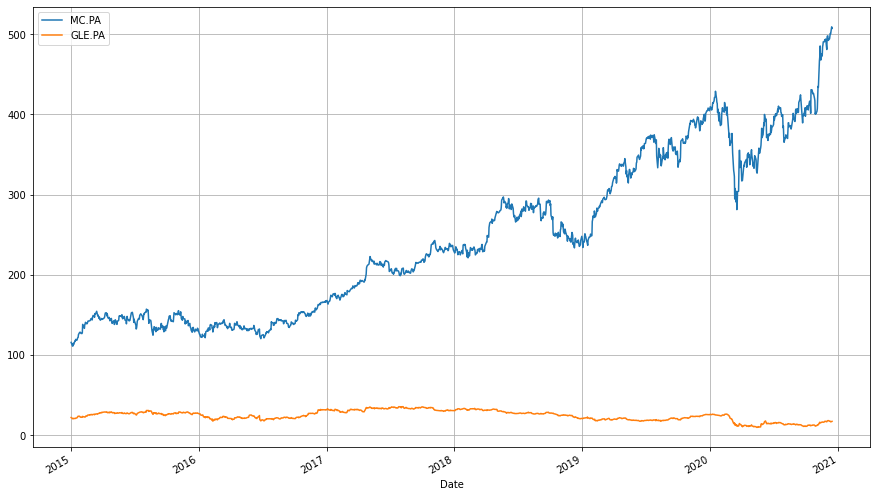

In [82]:
stocks.plot(grid = True)

Le problème d'un tel usage, est que les variations des deux cours ne sont pas bien représentées. Or ici c'est ce qui importe. Il faut donc représenter les cours sur deux échelles différentes pour mieux les observer. 

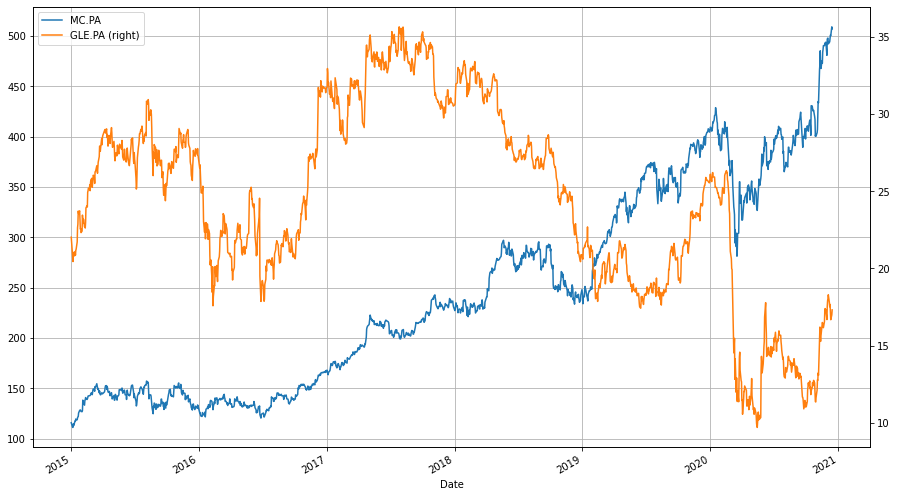

In [83]:
stocks.plot(secondary_y = ["GLE.PA"], grid = True)

Une deuxième façon de faire, est de représenter les returns des cours. 

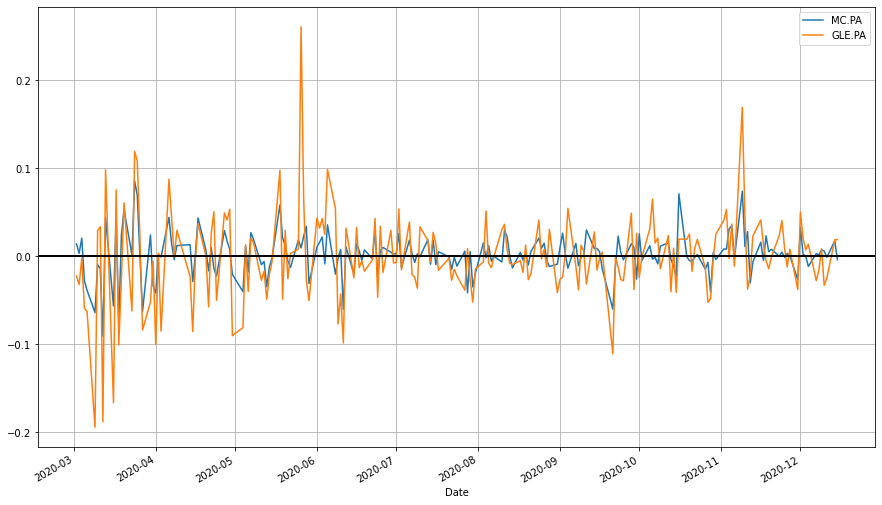

In [84]:
stock_return = stocks.apply(lambda x: np.log(x/x.shift(1)))
stock_return.loc['2020-03-01':].plot(grid = True).axhline(y = 0, color = "black", lw = 2)

In [85]:
def bollinger_bands(name, start, end):
    df = pdr.DataReader(name, 'yahoo', start, end)
   
    # On calcule la moyenne mobile 20, l'écart-type pour en déduire les bandes supérieures et inférieures
    df['20 Day MA'] = df['Adj Close'].rolling(window=20).mean()
    
    df['20 Day STD'] = df['Adj Close'].rolling(window=20).std() 
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    x_axis = df.index.get_level_values(0)
    
    # On remplit l'espace séparant les bandes supérieures et inférieures des bandes de Bollinger
    ax.fill_between(x_axis, df['Upper Band'], df['Lower Band'], color='grey')
    
    # On trace les prix ajustés de fermture et la moyenne mobile 20
    ax.plot(x_axis, df['Adj Close'], color='blue', lw=2)
    ax.plot(x_axis, df['20 Day MA'], color='r', lw=2)
    
    # Titre et présentation du graphe
    ax.set_title('20 Day Bollinger Band For {}'.format(name))
    ax.set_xlabel('Date (Year/Month)')
    ax.set_ylabel('Price(USD)')
    plt.grid(True)
    ax.legend() 

No handles with labels found to put in legend.


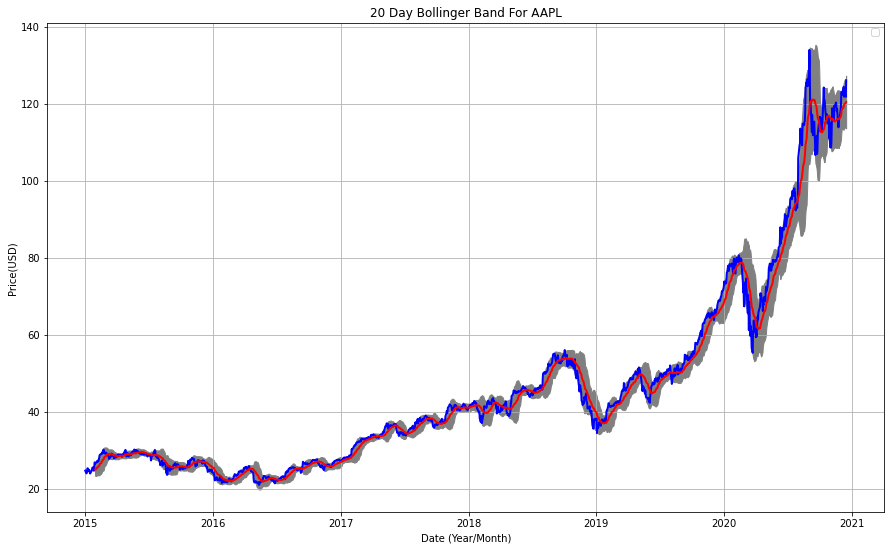

In [86]:
bollinger_bands('AAPL',start, end)

# Problème du Stock Split et Dividendes

Les dividendes rajoutés au portefeuille et les entreprises qui rajoutent des actions sur le marché sont deux problèmes pouvant affecter le cours de l'action, et donc par conséquent notre profit tel qu'il est calculé. 

Il faut donc recalculer ceci en considérent le prix ajusté, que nous fournit Yahoo dans les données. 

In [87]:
def ohlc_adj(dat):
    """
    :param dat: pandas DataFrame de données brutes issues de Yahoo ("Open", "High", "Low", "Close", and "Adj Close")  "Adj Close" les prix de fermeture ajustés

    :return: pandas DataFrame avec les données ajustées

    Cette fonction règle le problème des splits, des dividendes etc. 
    Retourne un tableau semblable aux données de Yahoo, mais avec les données réelles. 
    """
    return pd.DataFrame({"Open": dat["Open"] * dat["Adj Close"] / dat["Close"],
                       "High": dat["High"] * dat["Adj Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Adj Close"] / dat["Close"],
                       "Close": dat["Adj Close"]})

Désormais, on appliquera à chaque fois ohlc_adj sur les données téléchargées de Yahoo. 

# Méthode avec les Moyennes Mobiles Arithmétiques (MMA)

## Calcul des moyennes mobiles

In [88]:
lvmh_adj = ohlc_adj(data_cac40["lvmh"])
lvmh_adj.head()

,Open,High,Low,Close
Date,,,,
2015-01-02,117.200987,118.262427,114.901189,115.741508
2015-01-05,115.033871,116.626038,112.114901,112.380264
2015-01-06,112.424467,112.822512,111.009212,111.097664
2015-01-07,111.274570,111.584156,109.240136,111.186111
2015-01-08,112.778285,115.033853,111.761068,114.680031


On calcule les moyennes mobiles sur un cours, avec des périodes caractéristiques de 20, 50, et 200 jours. (périodes les plus utilisées)

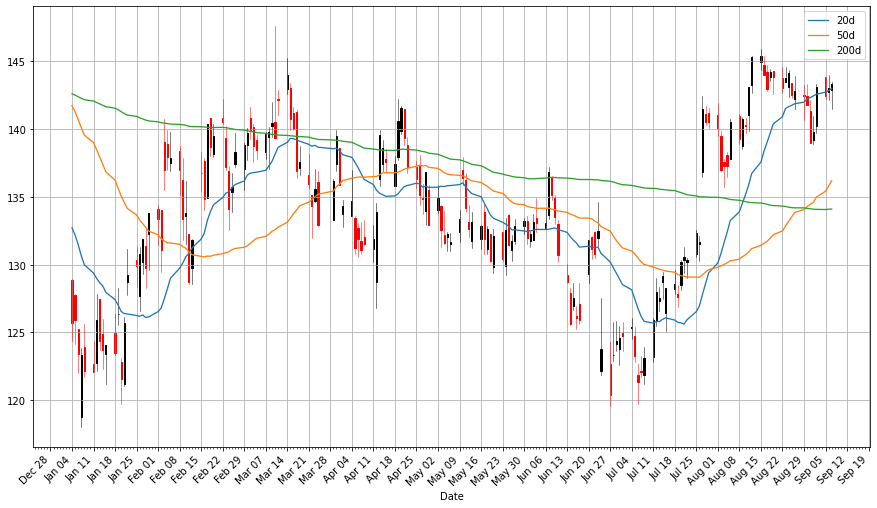

In [89]:
lvmh_adj["20d"] = lvmh_adj["Close"].rolling(window = 20, center = False).mean()
lvmh_adj["50d"] = lvmh_adj["Close"].rolling(window = 50, center = False).mean()
lvmh_adj["200d"] = lvmh_adj["Close"].rolling(window = 200, center = False).mean()
lvmh_adj.dropna(inplace=True)

pandas_candlestick_ohlc(lvmh_adj.loc['2016-01-04':'2016-09-07',:], otherseries = ["20d", "50d", "200d"])

Concrètement, les moyennes mobiles représentent la tendance du marché avec plus ou moins de précisions selon le nombre de jours pris en compte dans le calcul de ces moyennes. En effet, on peut voir ci-dessus que la moyenne mobile 200 jours nous renseigne sur la tendance à long terme avec un fort lissage des variations. Les moyennes mobiles plus courtes nous informent des changements rapides de tendances. 

Lorsque la moyenne à 20 jours se trouve au dessus de celle à 50 jours, la tendance est haussière et inversement. Ce graphique vient confirmer cette théorie sur plusieurs périodes. 

Cette méthode est très populaire pour analyser simplement les tendances de marché. Cependant, il faudra également prendre en compte d'autres indicateurs pour appuyer nos prises de décision, c'est-à-dire l'achat, la vente, ou le maintien de notre position.

## Trend Following Strategy

On calcule la différence entre les moyennes mobiles courte (20d) et longue (50d). Cela nous permet de créer une variable de régime afin de savoir si l'on se trouve dans un régime haussier ou baissier.

La méthode est la suivante : On produit un signal d'achat si la moyenne mobile 20 jours traverse la moyenne mobile 50 jours à la hausse et un signal de vente si elle la traverse à la baisse. Ce qui est important c'est le changement de signe de cette différence car il traduit l'entrée dans un nouveau régime (haussier ou baissier).

In [90]:
lvmh_adj['20d-50d'] = lvmh_adj['20d'] - lvmh_adj['50d']

lvmh_adj["Regime"] = np.where(lvmh_adj['20d-50d'] > 0, 1, 0)
lvmh_adj["Regime"] = np.where(lvmh_adj['20d-50d'] < 0, -1, lvmh_adj["Regime"])

lvmh_adj["Regime"].value_counts()

 1    863
-1    460
Name: Regime, dtype: int64

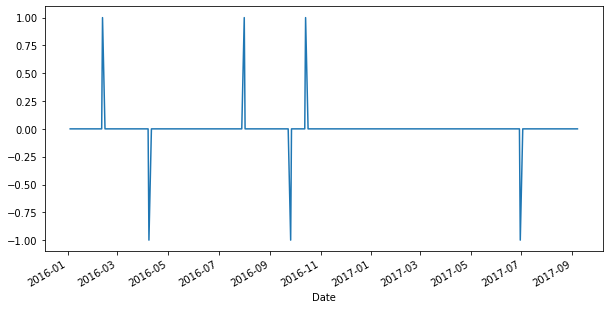

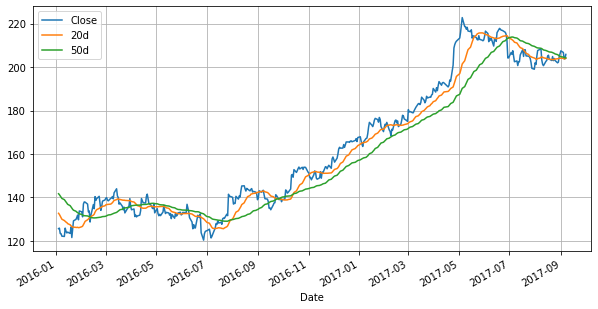

In [91]:
lvmh_adj["Regime"][-1] = 0

# Création du signal à l'aide de la comparaison entre deux régimes successifs
lvmh_adj["Signal"] = np.sign(lvmh_adj["Regime"] - lvmh_adj["Regime"].shift(1))
lvmh_adj.dropna(inplace=True)

# Répresentation graphique des moyennes mobiles et des signaux qui en découlent
lvmh_adj.loc['2016-01-04':'2017-09-07','Signal'].plot(figsize=(10,5))
lvmh_adj.loc['2016-01-04':'2017-09-07',['Close', '20d', '50d']].plot(figsize=(10,5), grid=True)

In [92]:
# On crée un tableau avec les opérations qui sont faites

lvmh_adj_signals = pd.concat([pd.DataFrame({"Price": lvmh_adj.loc[lvmh_adj["Signal"] == 1, "Close"],
                                            "Regime":lvmh_adj.loc[lvmh_adj["Signal"] == 1, "Regime"],
                                            "Signal": "Buy"}),
                              pd.DataFrame({"Price": lvmh_adj.loc[lvmh_adj["Signal"] == -1, "Close"],
                                            "Regime": lvmh_adj.loc[lvmh_adj["Signal"] == -1, "Regime"],
                                            "Signal": "Sell"}),])
lvmh_adj_signals.sort_index(inplace = True)

# J'enlève le premier ordre s'il s'agit d'une vente
if lvmh_adj_signals["Signal"][0] == "Sell" :
    lvmh_adj_signals.drop(lvmh_adj_signals.index[0], inplace = True)

lvmh_adj_signals.head()

,Price,Regime,Signal
Date,,,
2016-02-12,131.807541,1,Buy
2016-04-08,131.491592,-1,Sell
2016-08-01,140.060684,1,Buy
2016-09-26,139.007248,-1,Sell
2016-10-14,152.793457,1,Buy


In [93]:
# On crée un nouveau DataFrame comportant le prix au moment de l'achat, la date de vente et le profit réalisé au moment de celle-ci.
lvmh_adj_long_profits = pd.DataFrame({
    "Price": lvmh_adj_signals.loc[(lvmh_adj_signals["Signal"] == "Buy") & lvmh_adj_signals["Regime"] == 1, "Price"],
    
    "Profit": pd.Series(lvmh_adj_signals["Price"] - lvmh_adj_signals["Price"].shift(1)).loc[
        lvmh_adj_signals.loc[(lvmh_adj_signals["Signal"].shift(1) == "Buy") & (lvmh_adj_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
    
    "End Date": lvmh_adj_signals["Price"].loc[
        lvmh_adj_signals.loc[(lvmh_adj_signals["Signal"].shift(1) == "Buy") & (lvmh_adj_signals["Regime"].shift(1) == 1)].index
        ].index
    })

lvmh_adj_long_profits.tail()

,Price,Profit,End Date
Date,,,
2019-01-25,250.741241,87.451019,2019-08-14
2019-09-20,359.465881,7.916870,2019-10-11
2019-10-17,364.031464,41.300934,2020-02-14
2020-05-04,334.978058,54.601746,2020-08-12
2020-09-07,407.106903,100.093109,2020-12-15


In [94]:
lvmh_adj_long_profits['Profit'].sum()

390.8038635253906

Le profit réalisé sur toute la période de trading, uniquement sur l'action LVMH, a été de 337 euros environ.

On reprend ci-dessous le même DataFrame que précédemment en y ajoutant le niveau le plus bas de l'action sur toute la période de trading.

In [95]:
tradeperiods = pd.DataFrame({"Start": lvmh_adj_long_profits.index,
                             "End": lvmh_adj_long_profits["End Date"]})

lvmh_adj_long_profits["Low"] = tradeperiods.apply(lambda x: np.min(lvmh_adj.loc[x["Start"]:x["End"], "Low"]), axis = 1)

lvmh_adj_long_profits.head()

,Price,Profit,End Date,Low
Date,,,,
2016-02-12,131.807541,-0.315948,2016-04-08,128.602629
2016-08-01,140.060684,-1.053436,2016-09-26,133.511106
2016-10-14,152.793457,51.431030,2017-06-30,146.472874
2017-09-08,205.768082,21.445541,2018-01-02,204.037374
2018-03-09,231.592148,35.271805,2018-06-28,225.942412


## Résultats de la stratégie

Après avoir implémenté pas à pas la stratégie reposant sur les moyennes mobiles, nous allons maintenant la simuler complètement en nous imposant quelques contraintes cependant.

### Sur l'action LVMH seulement

In [96]:
cash = 1000000
lvmh_backtest = pd.DataFrame({"Start Port. Value": [],
                              "End Port. Value": [],
                              "End Date": [],
                              "Shares": [],
                              "Share Price": [],
                              "Trade Value": [],
                              "Profit per Share": [],
                              "Total Profit": [],
                              "Stop-Loss Triggered": []})

port_value = .1  # Proportion max de la valeur de notre portefeuille que l'on engage lors d'une opération
batch = 100      # Number of shares bought per batch
stoploss = .2    # On arrêtera si on perd 20% de notre capital initial à un moment donné.

for index, row in lvmh_adj_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    
    # Add a row to the backtest data frame containing the results of the trade
    lvmh_backtest = lvmh_backtest.append(pd.DataFrame({"Start Port. Value": cash,
                                                       "End Port. Value": cash + profit,
                                                       "End Date": row["End Date"],
                                                       "Shares": batch * batches,
                                                       "Share Price": row["Price"],
                                                       "Trade Value": trade_val,
                                                       "Profit per Share": share_profit,
                                                       "Total Profit": profit,
                                                       "Stop-Loss Triggered": stop_trig}, index = [index]))
    cash = max(0, cash + profit)

lvmh_backtest.head()

,Start Port. Value,End Port. Value,End Date,Shares,Share Price,Trade Value,Profit per Share,Total Profit,Stop-Loss Triggered
2016-02-12,1.000000e+06,9.997788e+05,2016-04-08,700.0,131.807541,92265.278625,-0.315948,-221.163940,0.0
2016-08-01,9.997788e+05,9.990414e+05,2016-09-26,700.0,140.060684,98042.478943,-1.053436,-737.405396,0.0
2016-10-14,9.990414e+05,1.029900e+06,2017-06-30,600.0,152.793457,91676.074219,51.431030,30858.618164,0.0
2017-09-08,1.029900e+06,1.040623e+06,2018-01-02,500.0,205.768082,102884.040833,21.445541,10722.770691,0.0
2018-03-09,1.040623e+06,1.054732e+06,2018-06-28,400.0,231.592148,92636.859131,35.271805,14108.721924,0.0


Text(0.5, 1.0, "Résultat du Trend Following sur l'action LVMH")

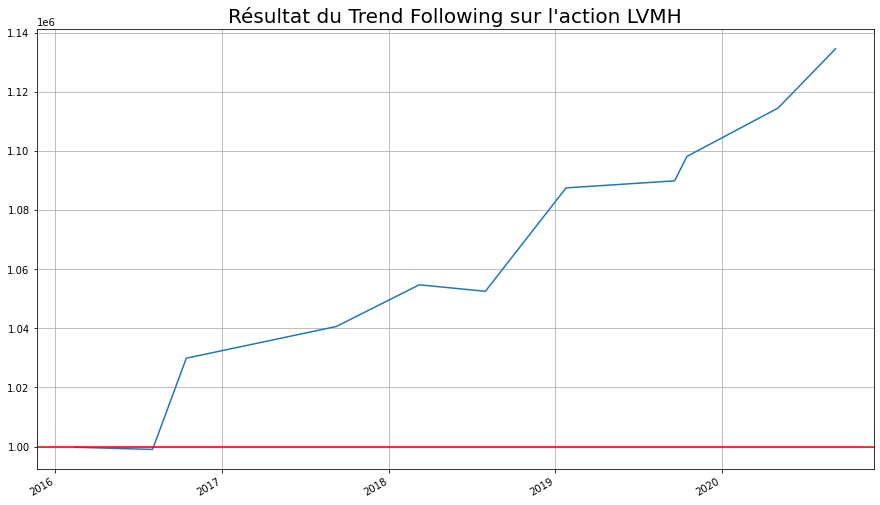

In [97]:
lvmh_backtest["End Port. Value"].plot(grid = True).axhline(y=1000000, color='red')
plt.title("Résultat du Trend Following sur l'action LVMH", fontsize=20)

### Sur un portefeuille diversifié ensuite

On peut maintenant essayer d'appliquer cette stratégie sur un portefeuille composé de plusieurs actions, tout en gardant les mêmes contraintes que précédemment.

In [98]:
def ma_crossover_orders(stocks, fast, slow):
    """
    :param stocks: Une liste de tuples (Symbole de l'action, données brutes de Yahoo) 
    :param fast: Int pour le nombre de jours utilisé pour la moyenne mobile courte
    :param slow: Int pour le nombre de jours utilisé pour la moyenne mobile longue

    :return: pandas DataFrame contenant les ordres à passer

    Cette fonction détermine quand chaque action doit être vendue ou achetée suivant la méthode des moyennes mobiles. 
    Pour chaque opération elle renvoie d'autres informations comme le cours de l'action à ce moment. 
    """
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str

    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        s[1][fast_str] = s[1]["Close"].rolling(window = fast, center = False).mean()
        s[1][slow_str] = s[1]["Close"].rolling(window = slow, center = False).mean()
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]

        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        regime_orig = s[1]["Regime"][-1]
        s[1]["Regime"][-1] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        s[1]["Regime"][-1] = regime_orig


        signals = pd.concat([pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Close"],
                                           "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                                           "Signal": "Buy"}),
                             pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Close"],
                                           "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                                           "Signal": "Sell"}),
                             ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)

    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])

    return trades

In [99]:
def backtest(signals, cash, port_value = .1, batch = 100):
    """
    :param signals: pandas DataFrame contenant les signaux d'achat/vente avec le symbole et le prix de ma_crossover_orders
    :param cash: integer pour la valeur initiale investie
    :param port_value: proportion maximale qu'on s'autorise à investir sur une opération
    :param batch: nombre d'actions contenu dans un paquet que l'on peut acheter

    :return: pandas DataFrame avec des résultats d'un backtest de la stratégie

    On se servira dans cette fonction de l'historique de la valeur du portefeuille afin de voir comment il évolue dans le temps. 
    """
    SYMBOL = 1 
    portfolio = dict()    
    port_prices = dict()  

    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})

    for index, row in signals.iterrows():
       
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   
        portfolio[index[SYMBOL]] = 0  

        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]

        if row["Signal"] == "Buy" and row["Regime"] == 1:
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) 
            trade_val = batches * batch * row["Price"] 
            cash_change -= trade_val  
            portfolio[index[SYMBOL]] = batches * batch  
            port_prices[index[SYMBOL]] = row["Price"] 
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1: #a short
            pass
            
        pprofit = row["Price"] - old_price   

        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance

    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
    return results

On applique notre strategie Trend Following sur un portefeuille diversifié de 10 actions. 
On utilise une somme d'argent de 1 000 000 d'euros. 

Text(0.5, 1.0, 'Résultat du Trend Following sur un portefeuille diversifié')

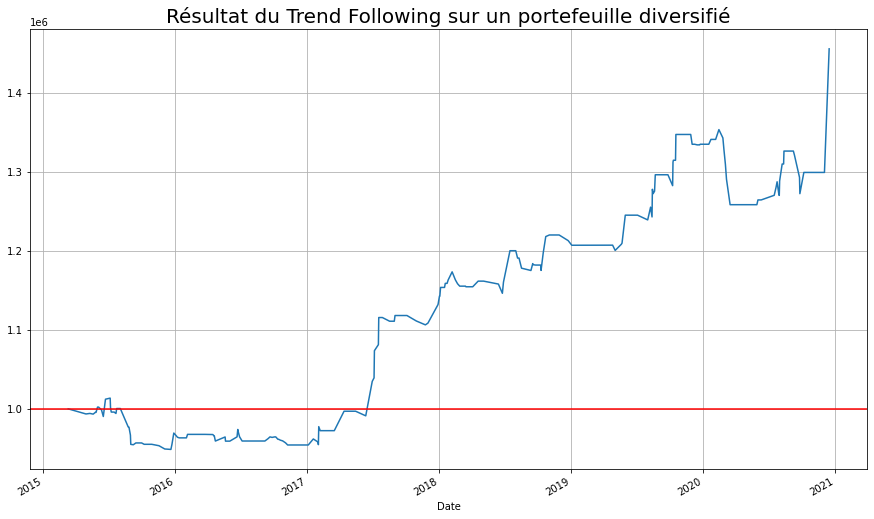

In [100]:
signals = ma_crossover_orders([("MC.PA", ohlc_adj(data_cac40['lvmh'])),
                              ("BN.PA",  ohlc_adj(data_cac40['danone'])),
                              ("HO.PA",  ohlc_adj(data_cac40['thales'])),
                              ("AIR.PA", ohlc_adj(data_cac40['airbus'])),
                              ("VIE.PA",  ohlc_adj(data_cac40['veolia'])),
                              ("DG.PA",   ohlc_adj(data_cac40['vinci'])),
                              ("UG.PA", ohlc_adj(data_cac40['peugeot'])),
                              ("CAP.PA",   ohlc_adj(data_cac40['capgemini'])),
                              ("CS.PA",   ohlc_adj(data_cac40['axa'])),
                              ("SAF.PA",   ohlc_adj(data_cac40['safran']))],
                              fast = 20, slow = 50)

bk = backtest(signals, 1000000)

bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot(grid=True).axhline(y=1000000, color='red')
plt.title("Résultat du Trend Following sur un portefeuille diversifié", fontsize=20)

In [101]:
signals = ma_crossover_orders([("MC.PA", ohlc_adj(data_cac40['lvmh'])[end3:end]),
                              ("BN.PA",  ohlc_adj(data_cac40['danone'])[end3:end]),
                              ("HO.PA",  ohlc_adj(data_cac40['thales'])[end3:end]),
                              ("AIR.PA", ohlc_adj(data_cac40['airbus'])[end3:end]),
                              ("VIE.PA",  ohlc_adj(data_cac40['veolia'])[end3:end]),
                              ("DG.PA",   ohlc_adj(data_cac40['vinci'])[end3:end]),
                              ("UG.PA", ohlc_adj(data_cac40['peugeot'])[end3:end]),
                              ("CAP.PA",   ohlc_adj(data_cac40['capgemini'])[end3:end]),
                              ("CS.PA",   ohlc_adj(data_cac40['axa'])[end3:end]),
                              ("SAF.PA",   ohlc_adj(data_cac40['safran'])[end3:end])],
                              fast = 20, slow = 50)

bk = backtest(signals, 1000000)

# Méthode avec le MACD : un indicateur plus fiable

On considère un nouvel indicateur : la MACD (Moving Average Convergence Divergence). 

Le MACD est calculé à partir des moyennes mobiles exponentielles (MME) 12 et MME 26.

$MME_m(t) = \alpha X_t + (1-\alpha) MME_m(t-1)$   où    $\alpha=\frac{2}{m+1}$

$MACD = MME_{12} - MME_{26}$



## Calcul de la MACD

In [102]:
# On utilise la commande de pandas pandas.Series.ewm pour calculer des fonctions exponentielles pondérées
# Création de la fonction qui va calculer la MACD
def calcul_MACD(df):
    
    df['e26'] = pd.Series.ewm(df['Close'], span=26).mean() #Calcul de la moyenne mobile exponentielle 26
    df['e12'] = pd.Series.ewm(df['Close'], span=12).mean() #Calcul de la moyenne mobile exponentielle 12
    df['MACD'] = df['e12'] - df['e26'] # Calcul de la MACD
    df['Signal line'] = pd.Series.ewm(df['MACD'], span=9).mean() #Calcul de la ligne de signal
    return df

# On applique cette fonction à notre DataFrame avec les données ajustées
calcul_MACD(lvmh_adj).head()

,Open,High,Low,Close,20d,50d,200d,20d-50d,Regime,Signal,e26,e12,MACD,Signal line
Date,,,,,,,,,,,,,,
2015-10-14,142.681182,144.829464,140.577672,142.546921,138.042280,137.503868,140.674896,0.538412,1,0.0,142.546921,142.546921,0.000000,0.000000
2015-10-15,143.084007,144.247645,139.637812,143.576309,138.257105,137.236228,140.830876,1.020877,1,0.0,143.081411,143.104506,0.023095,0.012831
2015-10-16,144.113412,144.113412,140.756733,142.009888,138.615153,136.971275,140.985437,1.643878,1,0.0,142.696423,142.677276,-0.019147,-0.000275
2015-10-19,141.965119,143.621072,141.025247,142.233643,138.917255,136.695579,141.140675,2.221675,1,0.0,142.567050,142.537238,-0.029811,-0.010280
2015-10-20,143.397306,144.113400,141.114762,141.696594,139.405093,136.578320,141.275758,2.826773,1,0.0,142.365188,142.308838,-0.056349,-0.023985


## Interprétation

### Interprétation 1 : croisement de la ligne de MACD et d'une une ligne de signal

Il faut étudier les croisements de la MACD avec un signal. Bien souvent, on prend le signal défini par la moyenne mobile exponentielle sur x jours (**généralement 9**) de la ligne de MACD.

Quand la ligne de MACD traverse à la hausse la ligne de signal, c'est un signal d'achat. A l'inverse quand la ligne de MACD traverse à la baisse la ligne de signal, c'est un signal de vente.
  

In [103]:
#Calcul du croisement de la ligne de MACD et de la ligne de signal
lvmh_adj['MACD-Signal'] = lvmh_adj['MACD']-lvmh_adj['Signal line']
lvmh_adj.head()

,Open,High,Low,Close,20d,50d,200d,20d-50d,Regime,Signal,e26,e12,MACD,Signal line,MACD-Signal
Date,,,,,,,,,,,,,,,
2015-10-14,142.681182,144.829464,140.577672,142.546921,138.042280,137.503868,140.674896,0.538412,1,0.0,142.546921,142.546921,0.000000,0.000000,0.000000
2015-10-15,143.084007,144.247645,139.637812,143.576309,138.257105,137.236228,140.830876,1.020877,1,0.0,143.081411,143.104506,0.023095,0.012831,0.010265
2015-10-16,144.113412,144.113412,140.756733,142.009888,138.615153,136.971275,140.985437,1.643878,1,0.0,142.696423,142.677276,-0.019147,-0.000275,-0.018872
2015-10-19,141.965119,143.621072,141.025247,142.233643,138.917255,136.695579,141.140675,2.221675,1,0.0,142.567050,142.537238,-0.029811,-0.010280,-0.019531
2015-10-20,143.397306,144.113400,141.114762,141.696594,139.405093,136.578320,141.275758,2.826773,1,0.0,142.365188,142.308838,-0.056349,-0.023985,-0.032364


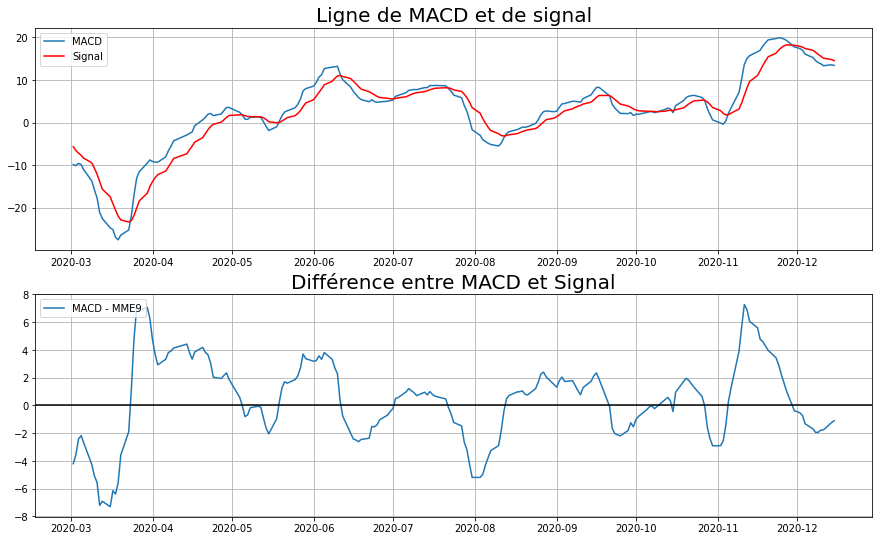

In [104]:
# Visualisation des croisements de la ligne de MACD et de la ligne de signal :
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)

# Visualisation de la ligne de MACD et du signal
ax1.plot(lvmh_adj.loc['2020-03-01':,'MACD'], label = 'MACD')
ax1.plot(lvmh_adj.loc['2020-03-01':,'Signal line'], label = 'Signal', c='red')
ax1.grid(True)
ax1.legend()
ax1.set_title("Ligne de MACD et de signal", fontsize=20)

ax2.plot(lvmh_adj.loc['2020-03-01':, 'MACD-Signal'], label = "MACD - MME9")
ax2.legend(loc='upper left')
ax2.grid(True)
ax2.set_title("Différence entre MACD et Signal", fontsize=20)
ax2.axhline(y=0, c='black')


Les pics "positifs" (respectivement "négatifs") de la courbe dans le deuxième graphique sont des signaux d'achat (respectivement de vente).

### Interprétation 2 : signe de la MACD

In [105]:
# On prend un nouveau dataframe pour garder lvmh_adj clean
very_new_lvmh_adj=lvmh_adj.copy()
very_new_lvmh_adj.head()

,Open,High,Low,Close,20d,50d,200d,20d-50d,Regime,Signal,e26,e12,MACD,Signal line,MACD-Signal
Date,,,,,,,,,,,,,,,
2015-10-14,142.681182,144.829464,140.577672,142.546921,138.042280,137.503868,140.674896,0.538412,1,0.0,142.546921,142.546921,0.000000,0.000000,0.000000
2015-10-15,143.084007,144.247645,139.637812,143.576309,138.257105,137.236228,140.830876,1.020877,1,0.0,143.081411,143.104506,0.023095,0.012831,0.010265
2015-10-16,144.113412,144.113412,140.756733,142.009888,138.615153,136.971275,140.985437,1.643878,1,0.0,142.696423,142.677276,-0.019147,-0.000275,-0.018872
2015-10-19,141.965119,143.621072,141.025247,142.233643,138.917255,136.695579,141.140675,2.221675,1,0.0,142.567050,142.537238,-0.029811,-0.010280,-0.019531
2015-10-20,143.397306,144.113400,141.114762,141.696594,139.405093,136.578320,141.275758,2.826773,1,0.0,142.365188,142.308838,-0.056349,-0.023985,-0.032364


In [106]:
# Fonction pour signaler l'achat ou la vente d'une action
def buy_sell(df):
  Buy = []
  Sell = []
  flag = -1

  for i in range(0, len(df)):
    if df['MACD'][i] > df['Signal line'][i] :
      Sell.append(np.nan)
      if flag != 1: #première fois qu'on passe par là
        Buy.append(df['Close'][i])
        flag = 1
      else :
        Buy.append(np.nan)
    elif df['MACD'][i] < df['Signal line'][i] :
      Buy.append(np.nan)
      if flag != 0: #première fois qu'on passe par là
        Sell.append(df['Close'][i])
        flag = 0
      else :
        Sell.append(np.nan)
    else :
      Buy.append(np.nan)
      Sell.append(np.nan)
  
  return Buy, Sell

In [107]:
# Création des colonnes représentant les signaux
very_new_lvmh_adj['Buy_Signal_Price'] = buy_sell(very_new_lvmh_adj)[0]
very_new_lvmh_adj['Sell_Signal_Price'] = buy_sell(very_new_lvmh_adj)[1]
very_new_lvmh_adj.head()

,Open,High,Low,Close,20d,50d,200d,20d-50d,Regime,Signal,e26,e12,MACD,Signal line,MACD-Signal,Buy_Signal_Price,Sell_Signal_Price
Date,,,,,,,,,,,,,,,,,
2015-10-14,142.681182,144.829464,140.577672,142.546921,138.042280,137.503868,140.674896,0.538412,1,0.0,142.546921,142.546921,0.000000,0.000000,0.000000,NaN,NaN
2015-10-15,143.084007,144.247645,139.637812,143.576309,138.257105,137.236228,140.830876,1.020877,1,0.0,143.081411,143.104506,0.023095,0.012831,0.010265,143.576309,NaN
2015-10-16,144.113412,144.113412,140.756733,142.009888,138.615153,136.971275,140.985437,1.643878,1,0.0,142.696423,142.677276,-0.019147,-0.000275,-0.018872,NaN,142.009888
2015-10-19,141.965119,143.621072,141.025247,142.233643,138.917255,136.695579,141.140675,2.221675,1,0.0,142.567050,142.537238,-0.029811,-0.010280,-0.019531,NaN,NaN
2015-10-20,143.397306,144.113400,141.114762,141.696594,139.405093,136.578320,141.275758,2.826773,1,0.0,142.365188,142.308838,-0.056349,-0.023985,-0.032364,NaN,NaN


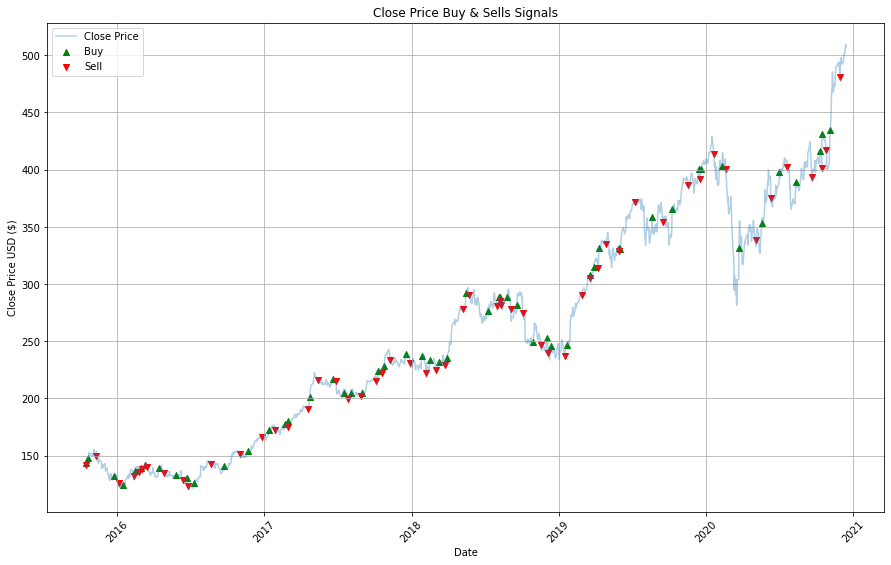

In [108]:
#Visually show the stock buy and sell signal
plt.figure()
plt.scatter(very_new_lvmh_adj.index, very_new_lvmh_adj['Buy_Signal_Price'], color='green', label='Buy', marker='^', alpha=1)
plt.scatter(very_new_lvmh_adj.index, very_new_lvmh_adj['Sell_Signal_Price'], color='red', label='Sell', marker='v', alpha=1)
plt.plot(very_new_lvmh_adj['Close'], label = 'Close Price', alpha = 0.35)

plt.title('Close Price Buy & Sells Signals')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc = 'upper left')
plt.grid(True)

# Méthode avec le RSI : Relative Strength Index


Le RSI est un indicateur qui permet de prévoir un changement de tendance, ou à défaut examine la force d'une tendance particulière.

Le RSI mesure ainsi la force interne d'un titre, c'est à dire que l'on ne compare pas le titre à un indice.






##  Nature
Le RSI est un indicateur compris entre 0 et 100. Comme son nom l'indique, il ne fait qu'interpréter une tendance en donnant une indication.
- Si le RSI est compris vers 50 : 
C'est là qu'on observera le plus de changements de tendances car le marché se trouve dans un état d'équilibre sur la période de temps choisie. 
- Si le RSI est supérieur à 70 : Le marché est en sur-achat et il faut certainement prévoir un affaiblissement de la tendance correspondante.
-  Si le RSI est inférieur à 30 : Le marché est en sur-vente et il faut certainement prévoir un affaiblissement de la tendance.





## Exemple de stratégie de trading avec le RSI
- Si le RSI dépasse 70 et qu'il revient couper 70 : cela peut signifier qu'une baisse ou des prises de bénéfices sont en cours et le trader aura tendance à vendre.
- Si le RSI passe sous la barre des 30 puis revient la couper : cela peut singnifier qu'une hausse est en cours et le trader aura donc tendance à acheter.


## Calcul



RSI = $100-\frac{100}{1+\frac{H}{B}}$

- H est la moyenne des gains sur la période choisie (unité de temps) 
- B est la moyenne des baisses sur la période choisie (unité de temps)

La valeur du RSI dépend donc de la méthode choisie pour calculer les moyennes, de la période sur laquelle on le calcule.

Exemples : 
- RSI 9 sur un graphique en 2min : le RSI correspond à la moyenne sur les 2x9 = 18 dernières minutes. Donc en toute logique, si le trader achète avec ce RSI, il est prêt à maintenir cette position entre 2 et 18 minutes.
- RSI 14 sur un graphique de 5min : Le RSI correspond à la moyenne sur les 70 dernières minutes.
- RSI 25 sur un graphique en 1 journée : si le trader achète, il est prêt à investir sur les 25x1 prochaines journées.

On fait ensuite le choix de calculer le RSI avec des moyennes mobiles. 

In [109]:
def RSI_mobile(stock, time):
  """ Calcul du RSI en utilisant des moyennes mobiles"""
  # On va moyenner sur les valeurs à la fermeture
  close = stock['Close']
  # Calcul de la différence avec la marche précédente
  delta = close.diff()  
  # On ne conserve que les time dernières lignes, sur lesquelles on veut calculer le RSI
  delta = delta[1:]
  # On veut une moyenne des hausses (H) et une moyenne des baisses (B)
  up, down = delta.copy(), delta.copy() # On copie le DataFrame delta 2 fois dans les tables up et down
  # On supprime les hausses de down et les baisses de up
  up[up < 0] = 0 
  down[down > 0] = 0 
  # On calcule les moyennes arithmétiques respectives de up et down 
  H = up.rolling(time,center = False).mean()
  B = down.rolling(time, center = False).mean().abs()
  rsi = 100-(100/(1+H/B))
  return rsi


In [110]:
RSI_mobile(lvmh_adj[start:end], 14)

Date
2015-10-15          NaN
2015-10-16          NaN
2015-10-19          NaN
2015-10-20          NaN
2015-10-21          NaN
                ...    
2020-12-09    61.292623
2020-12-10    60.601141
2020-12-11    59.934628
2020-12-14    64.516546
2020-12-15    63.007632
Name: Close, Length: 1321, dtype: float64

# Méthode avec le Stochastique



##Présentation



**Calcul**

%$K=100 \times \frac{(Prix-de-cloture-actuel)  -  B_n}{H_n-B_n}$

Avec $B_n$ pour le prix le plus bas et $H_n$ pour le prix le plus haut sur $n$ périodes (généralement 14 jours)


\\
%$D$ = la moyenne mobile de %$K$ sur $n$ périodes 

\\
**Période : 14 jours**

 1ère interprétation :
Si le prix de clôture actuel est proche du prix le plus haut (Hn) de la période concerné, le Stochastique sera proche de 100%

Si le prix de clôture actuel est proche du prix le plus bas (Bn) de la période concerné, le Stochastique sera proche de 0%

Si la ligne %K atteint la zone des 80%, l'actif est considéré en surévaluation

SI la ligne %D atteint la zone des 20%, l'actif est considéré en sous-évaluation

**Croisement**

Si la ligne %K croise par le haut la ligne %D, l'indicateur produit un signal d'achat.
Si la ligne %K croise par le bas la ligne %D , l'indicateur produit un signal de vente.

**Croisement avec la barre des 50%**

Si la ligne %K croise par le haut la ligne horizontale du milieu, l'indicateur produit un signal d'achat.
Si la ligne %K croise par le bas la ligne horizontale du milieu, l'indicateur produit un signal de vente.

**Niveau de %K**

Si la ligne %K se trouve au-dessus des 80%, alors un croisement à la baisse de la ligne horizontale haute (80%) produit un signal de vente.
Si la ligne %K se trouve en-dessous des 20%, alors un croisement à la hausse de la ligne horizontale basse produit un signal d'achat.

**Divergence **

La divergence **haussière** se traduit par la formation de deux bas consécutifs du cours avec le bas le plus récent plus bas que son précédent tandis qu'au même moment, l'indicateur Stochastique réalise deux bas dont le plus récent est quant à lui plus haut que son bas précédent.
La divergence baissière se traduit par la formation de deux sommets consécutifs avec le sommet le plus récent plus haut que son précédent tandis qu'au même moment, l'indicateur Stochastique MT4 réalise deux sommets dont le plus récent est quant à lui plus bas que son bas précédent.

## Calcul du stochastique

In [111]:
N = 14

lvmh_adj["K"] = 100*(lvmh_adj["Close"]-lvmh_adj["Low"].rolling(window = N).min())/(lvmh_adj["High"].rolling(window = N).max()- lvmh_adj["Low"].rolling(window = N).min())
lvmh_adj["D"] = lvmh_adj["K"].rolling(window = N).mean()

stochastique = pd.DataFrame({"K" : lvmh_adj["K"],
                             "D" : lvmh_adj["D"]})

stochastique.tail()

,K,D
Date,,
2020-12-09,87.244902,86.301625
2020-12-10,93.488400,85.998411
2020-12-11,84.782609,85.376330
2020-12-14,90.415341,85.075056
2020-12-15,76.676397,83.883551


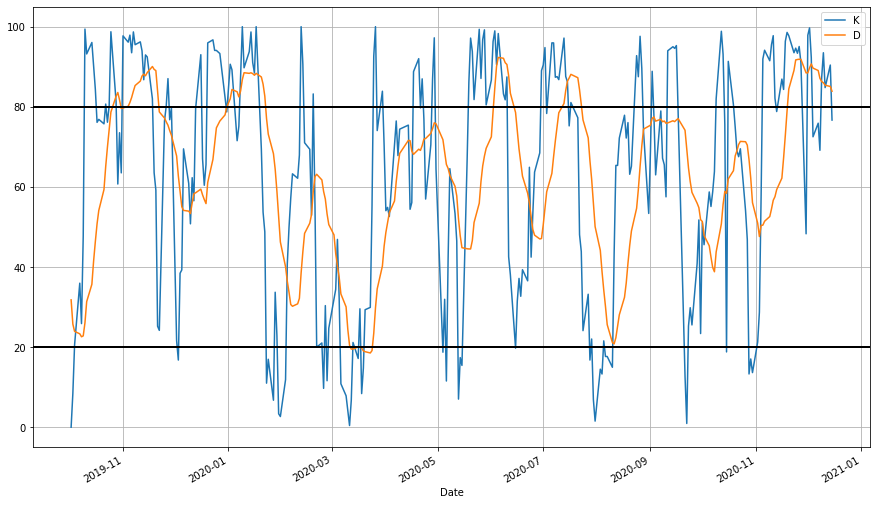

In [112]:
stochastique.loc['2019-10-02':end,:].plot(grid=True).axhline(y = 20, color = "black", lw = 2)
plt.axhline(y=80, color = 'black', lw = 2)

In [113]:
lvmh_adj["K-80"] = lvmh_adj["K"] - 80
lvmh_adj["K-50"] = lvmh_adj["K"] - 50
lvmh_adj["K-20"] = lvmh_adj["K"] - 20
lvmh_adj["K-D"] = lvmh_adj["K"] - lvmh_adj["D"]

lvmh_adj.dropna(inplace=True)
lvmh_adj.head()

,Open,High,Low,Close,20d,50d,200d,20d-50d,Regime,Signal,e26,e12,MACD,Signal line,MACD-Signal,K,D,K-80,K-50,K-20,K-D
Date,,,,,,,,,,,,,,,,,,,,,
2015-11-19,147.693865,148.275683,144.739985,145.366562,150.191214,143.234387,144.002555,6.956827,1,0.0,148.643617,148.076646,-0.566971,0.143017,-0.709987,32.386525,57.635603,-47.613475,-17.613475,12.386525,-25.249078
2015-11-20,146.395920,146.395920,144.381914,145.232269,149.815266,143.486809,144.038115,6.328457,1,0.0,148.357793,147.634941,-0.722853,-0.030493,-0.692360,31.534091,54.350590,-48.465909,-18.465909,11.534091,-22.816499
2015-11-23,145.456050,145.500808,143.397285,144.918976,149.490788,143.741021,144.070339,5.749766,1,0.0,148.072440,147.213785,-0.858655,-0.196382,-0.662273,29.545434,50.062651,-50.454566,-20.454566,9.545434,-20.517217
2015-11-24,143.307799,143.710598,136.504925,138.697952,148.884346,143.831428,144.059960,5.052918,1,0.0,147.301411,145.894873,-1.406538,-0.438713,-0.967825,11.238527,43.977650,-68.761473,-38.761473,-8.761473,-32.739123
2015-11-25,139.055992,142.412671,139.055992,141.428040,148.450215,143.875288,144.066106,4.574927,1,0.0,146.822256,145.203773,-1.618483,-0.674901,-0.943582,26.442213,39.045454,-53.557787,-23.557787,6.442213,-12.603242


In [114]:
#Note 0 : acheter et 5 : vendre

def test_tab_bool(t1,t2):
  t = t1.copy()
  for i in range(len(t1)):
    t[i] = t1[i] and t2[i]
  return t

# on met 5 si K < 20 et K traverse D à la hausse

t = np.where(test_tab_bool(test_tab_bool((lvmh_adj[N+1:]["K-D"][1:]>0),(lvmh_adj[15:]["K-D"].shift(1)[1:]<0)), (lvmh_adj[15:]["K-20"].shift(1)[1:]<0)) ,5,2.5)
lvmh_adj["Note"] = np.concatenate((np.array((N+2)*[-1.]),t))


# on met 0 si K>80 et K traverse D à la baisse
t_2 = np.where(test_tab_bool((lvmh_adj[N+1:]["K-D"][1:]<0),test_tab_bool((lvmh_adj[N+1:]["K-D"].shift(1)[1:]>0),(lvmh_adj[N+1:]["K-80"].shift(1)[1:]>0))),0,lvmh_adj[N+2:]["Note"])
lvmh_adj["Note"] = np.concatenate((np.array((N+2)*[-1.]) ,t_2))

lvmh_adj["Note"].value_counts()


 2.5    1167
 0.0      79
 5.0      34
-1.0      16
Name: Note, dtype: int64

## Résultats du stochastique

In [115]:
def ma_crossover_orders(stocks, bas, haut, N):
    """
    :param stocks: Une liste de tuples (Symbole de l'action, données brutes de Yahoo) 
    :param bas: Int pour le seuil minimum que le stochastique peut franchir avant de considérer l'action en sur-vente
    :param haut: Int pour le seuil maximum que le stochastique peut franchir avant de considérer l'action en sur-achat
    :param N: Int pour la période du stochastique
    :return: pandas DataFrame contenant les ordres à passer

    Cette fonction détermine quand chaque action doit être vendue ou achetée suivant la méthode du stochastique.  
    Pour chaque opération elle renvoie d'autres informations comme le couurs de l'action à ce moment. 
    """
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        s[1]["K"] = 100 *(s[1]["Close"]-s[1]["Low"].rolling(window=N).min())/(s[1]["High"].rolling(window = N).max()- s[1]["Low"].rolling(window = N).min())
        s[1]["D"] = s[1]["K"].rolling(window=N).mean()

        s[1]["K-"+str(haut)] = s[1]["K"] - haut
        s[1]["K-50"] = s[1]["K"] -50
        s[1]["K-"+str(bas)] = s[1]["K"] - bas
        s[1]["K-D"] = s[1]["K"] - s[1]["D"]

        # on met 5 si K <20 et K traverse D à la hausse
        t = np.where(test_tab_bool(test_tab_bool((s[1][N+1:]["K-D"][1:]>0),(s[1][N+1:]["K-D"].shift(1)[1:]<0)), (s[1][N+1:]["K-20"].shift(1)[1:]<0)) ,5,2.5)
        s[1]["Note"] = np.concatenate((np.array((N+2)*[-1.]),t))

        # on met 0 si K>80 et K traverse D à la baisse
        t_2 = np.where(test_tab_bool((s[1][N+1:]["K-D"][1:]<0),test_tab_bool((s[1][N+1:]["K-D"].shift(1)[1:]>0),(s[1][N+1:]["K-80"].shift(1)[1:]>0))),0,s[1][N+2:]["Note"])
        s[1]["Note"] = np.concatenate((np.array((N+2)*[-1.]) ,t_2))

        # Get signals
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Note"] == 5, "Close"],
                          "Regime": s[1].loc[s[1]["Note"] == 5, "Note"],
                          "Signal": "Acheter"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Note"] == 0, "Close"],
                          "Regime": s[1].loc[s[1]["Note"] == 0, "Note"],
                          "Signal": "Vendre"}),
        ])

        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)

    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])

    return trades

Text(0.5, 1.0, "Résultat du stochastique sur une période d'un an")

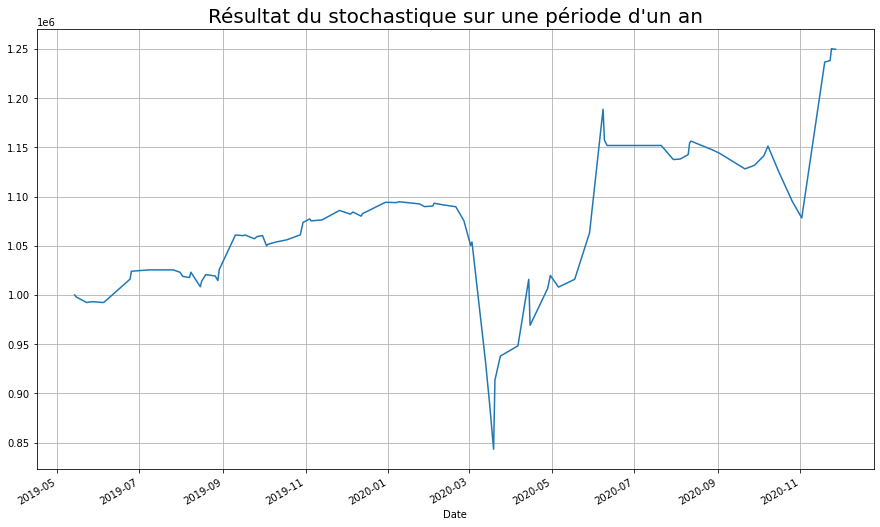

In [116]:
def backtest(stocks, cash, portfolio = dict(),port_prices = dict()):
    """
    :param stocks: Une liste de tuples (Symbole de l'action, données brutes de Yahoo)
    :param cash: integer pour la valeur initiale investie
    :param portfolio: dictionnaire avec les actions détenues
    :param port_prices: dictionnaire avec le prix des actions détenues

    :return: pandas DataFrame avec des résultats d'un backtest de la stratégie

    On se servira dans cette fonction de l'historique de la valeur du portefeuille afin de voir comment il évolue dans le temps. 
    """

    signals = ma_crossover_orders(stocks, 20, 80, 14)

    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})

    for index, row in signals.iterrows():

        #valeur du portefeuille avant l'opération
        portfolio_val = 0 
        for key, val in portfolio.items():
            for i,dat in stocks :
                if key ==i:
                    port_prices[key] = dat.loc[str(index[0].date()),"Close"]
            portfolio_val += val * port_prices[key]

        shares = portfolio[index[1]]
        old_price = port_prices[index[1]]
        
        n_max = np.floor((portfolio_val + cash)/(row["Price"]*len(portfolio)))

        if row["Signal"]=="Acheter" and shares<n_max :
            trade_val = (n_max-shares)*row["Price"]
            portfolio[index[1]]=n_max
            port_prices[index[1]] = (shares*port_prices[index[1]]+(n_max-shares)*row["Price"])/(n_max)
            # Update report
            results = results.append(pd.DataFrame({
                    "Start Cash": cash,
                    "End Cash": cash - trade_val,
                    "Portfolio Value":cash + portfolio_val,
                    "Type": row["Signal"],
                    "Shares": n_max - shares,
                    "Share Price": row["Price"],
                    "Trade Value": trade_val,
                    "Profit per Share": old_price - port_prices[index[1]],
                    "Total Profit": (n_max - shares) * (old_price - port_prices[index[1]])
                }, index = [index]))
            cash -= trade_val

    
        elif row["Signal"]=="Vendre" and shares > 0:
            trade_val = shares * row["Price"]
            portfolio[index[1]]= 0
            port_prices[index[1]] = row["Price"]
            # Update report
            results = results.append(pd.DataFrame({
                    "Start Cash": cash,
                    "End Cash": cash + trade_val,
                    "Portfolio Value":cash +portfolio_val,
                    "Type": row["Signal"],
                    "Shares": shares ,
                    "Share Price": row["Price"],
                    "Trade Value": trade_val,
                    "Profit per Share": port_prices[index[1]],
                    "Total Profit": shares* (port_prices[index[1]] - old_price)
                }, index = [index]))
            
            cash += trade_val

        else : pass 

    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
    return results

stocks = [("MC.PA",ohlc_adj(data_cac40["lvmh"])[end3:end]),
                              ("BN.PA",ohlc_adj(data_cac40["danone"])[end3:end]),
                              ("HO.PA",ohlc_adj(data_cac40["thales"])[end3:end]),
                              ("AIR.PA",ohlc_adj(data_cac40["airbus"])[end3:end]),
                              ("VIE.PA",ohlc_adj(data_cac40["veolia"])[end3:end]),
                              ("DG.PA",ohlc_adj(data_cac40["vinci"])[end3:end]),
                              ("UG.PA",ohlc_adj(data_cac40["peugeot"])[end3:end]),
                              ("CAP.PA",ohlc_adj(data_cac40["capgemini"])[end3:end]),
                              ("CS.PA",ohlc_adj(data_cac40["axa"])[end3:end]),
                              ("SAF.PA",ohlc_adj(data_cac40["safran"])[end3:end])]

portfolio = {"MC.PA" : 0, "BN.PA" : 0,"HO.PA":0, "AIR.PA":0,"VIE.PA":0,"DG.PA":0,"UG.PA":0,"CAP.PA":0,"CS.PA":0,"SAF.PA":0}
port_prices = {"MC.PA" : 0, "BN.PA" : 0,"HO.PA":0, "AIR.PA":0,"VIE.PA":0,"DG.PA":0,"UG.PA":0,"CAP.PA":0,"CS.PA":0,"SAF.PA":0}

bk_sto = backtest(stocks, 1000000, portfolio, port_prices) #commenté pour gagner du temps à compiler

bk_sto["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot(grid=True)
plt.title("Résultat du stochastique sur une période d'un an", fontsize=20)

# Momentum 

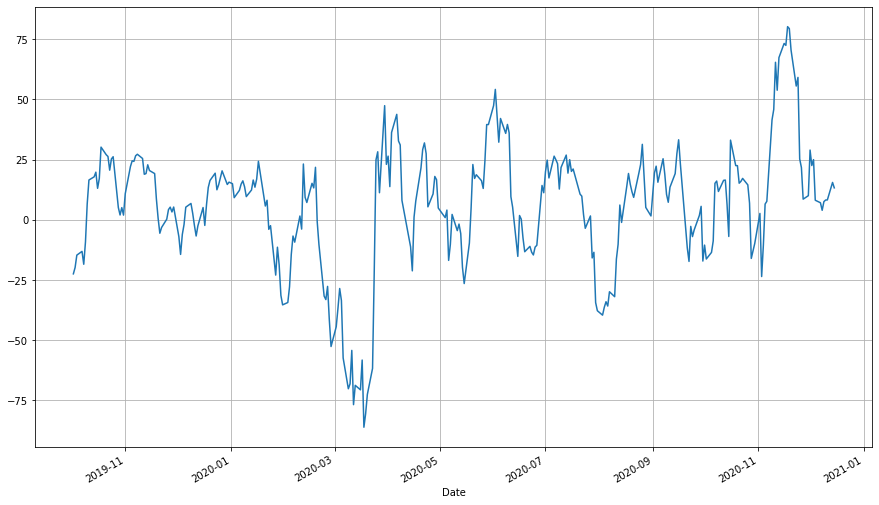

In [117]:
N = 12

lvmh_adj["momentum"] = lvmh_adj["Close"] - lvmh_adj["Close"].shift(N)
lvmh_adj["momentum"].loc['2019-10-02':end].plot(grid=True)

# CAPM

Le "Capital Asset Pricing Model" (CAPM) ou Modèle d'évaluation des actifs financiers (MEDAF) est le modèle d'évaluation le plus célèbre et le plus utilisé malgré le fait que sa pertinence empirique soit très discutée.
En effet, l'univers du CAPM doit obéir à certaines règles bien précises pour que la formule de la rentabilité de l'actif fonctionne. Voici les différentes hypothèses de bases : 
- il n'y a pas de coûts de transactions ou de taxes
- la vente à découvert ou l'achat d'un titre n'a aucune incidence sur son prix
- les investisseurs sont averses au risque et rationnels
- tous les investisseurs ont le même horizon d'investissement
- les investisseurs contrôlent le risque de leur portefeuille par la diversification
- le marché est entièrement libre et tous les actifs peuvent y être échangés.
- les investisseurs peuvent emprunter et prêter des montants illimités au taux sans risque
- toutes les informations sur le marché sont disponibles pour tous les investisseurs
- la concurrence sur les marchés et parfaite et non faussée
- tous les actifs financiers peuvent être divisés en actifs de plus petite taille

In [118]:
risk_free_return = 0.05 #taux du livret A par exemple

In [119]:
def capm(df1, df2, start, end):
    """
    :param df1: pandas DataFrame de données brutes issues de Yahoo ("Open", "High", "Low", "Close", and "Adj Close")
    :param df2: pandas DataFrame de données brutes issues de Yahoo ("Open", "High", "Low", "Close", and "Adj Close")
    :param start: str de la première date de la période
    :param end: str de la dernière date de la période
    
    :return: beta, CAPM
    
    Calcule le beta et le CAPM sur une période, à la date end. 
    CAPM = r_f + beta * (market_return - r_f)
    
    r_f : taux d'un placement sans risque : livret A en France
    market_retun : rentabilité esperée du marché : rentabilité historique 
    beta : beta de l'actif financier df1

    """

    stock1 = df1[start:end]
    stock2 = df2[start:end]

    #On garde les lignes à une période d'un mois
    return_s1 = stock1.resample('M').last()
    return_s2 = stock2.resample('M').last()
    
    data = pd.DataFrame({'s_adjclose' : return_s1['Adj Close'], 'm_adjclose': return_s2['Adj Close']}, index=return_s1.index)
    
    data[['s_returns','m_returns']] = np.log(data[['s_adjclose', 'm_adjclose']]/data[['s_adjclose', 'm_adjclose']].shift(1))
    
    data = data.dropna() #on enlève les valeurs nulles

    covmat = np.cov(data["s_returns"], data["m_returns"])
    beta = covmat[0,1]/covmat[1,1]

    return beta,risk_free_return + beta*(data["m_returns"].mean()*12-risk_free_return)


capm(data_cac40["lvmh"], cac40, "01 01 2016", "14 10 2019")

(1.1990126946441186, 0.06837359526704702)

Le Beta de l'actif financier se définit comme le rapport de la covariance de la rentabilité de l'actif avec celle du marché à la variance de la rentabilité du marché.

on a ainsi la formule suivante : Beta = Covariance (R.actif, R.marché) / Variance (R.marché).

In [120]:
def tab_capm(df, start,end,N):
  """
  Retourne un tableau numpy avec le capm calculé à partir du jour Start + Njours
  Pour les premiers jours, on met une valeur nulle car il n'y a pas assez de valeur avant pour calculer le capm. 
  """
  d = pd.Timedelta('1 day')
  res = []

  while start + 70*d != end:
      try :
          s = df.loc[str(end)]
          res.append(capm(df, cac40, max(end - N*d, start) ,end)[1])
      except KeyError :
          pass
      end = end -d 
  
  for i in range(71):
    try :
        s = df.loc[str(start+i*d)]
        res.append(0)
    except KeyError :
        pass
  
  return np.array(res)[::-1]

# Scraping des facteurs macro-économiques

In [121]:
# télécharger les données sur ce site : http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#International
# Données journalières qui renseigne de l'actualité macroéconomique dans plusieurs région du monde

"On importe les modules nécessaires au web scraping" 
import requests
import urllib.request
from bs4 import BeautifulSoup
"On récupère le lien du site que l'on souhaite scraper"
url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#International'
response = requests.get(url)
print (response) #Si 200 s'affiche cela signifie que l'accès au site a fonctionné

"On extrait le code source au format BeautifulSoup"
soup = BeautifulSoup(response.text, "html.parser")

"print(soup.findAll('a')) #La ligne qui nous intéresse est la 512"
target = soup.findAll('a')[512]
link = target['href']

"On extrait le tableau de données au format CSV"
download_url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/' + link
urllib.request.urlretrieve(download_url,'Europe_5_Factors_Daily_CSV.zip' )

<Response [200]>


('Europe_5_Factors_Daily_CSV.zip', <http.client.HTTPMessage at 0x7fbcdd1c9710>)

On extrait ensuite le fichier CSV que l'on transforme en fichier xlsx (on utilise les virgules comme séparateur) et on importe le fichier excel manuellement dans le colab/notebook



In [137]:
import zipfile
with zipfile.ZipFile("/content/Europe_5_Factors_Daily_CSV.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [149]:
macro = pd.read_csv("/content/Europe_5_Factors_Daily.csv",",",skiprows=[0,1,2])

macro.info()
macro.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7893 entries, 0 to 7892
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7893 non-null   int64  
 1   Mkt-RF      7893 non-null   float64
 2   SMB         7893 non-null   float64
 3   HML         7893 non-null   float64
 4   RMW         7893 non-null   float64
 5   CMA         7893 non-null   float64
 6   RF          7893 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 431.8 KB


,Unnamed: 0,Mkt-RF,SMB,HML,RMW,CMA,RF
count,7.893000e+03,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000
mean,2.005189e+07,0.022206,-0.000303,0.008508,0.018613,0.005770,0.009724
std,8.740510e+04,1.138041,0.590588,0.439958,0.284996,0.325113,0.008750
min,1.990070e+07,-12.000000,-5.320000,-4.180000,-2.350000,-2.470000,0.000000
25%,1.998012e+07,-0.500000,-0.280000,-0.190000,-0.130000,-0.150000,0.000000
50%,2.005082e+07,0.060000,0.010000,0.010000,0.020000,0.000000,0.010000
75%,2.013031e+07,0.580000,0.310000,0.210000,0.180000,0.150000,0.020000
max,2.020093e+07,10.760000,3.320000,3.760000,4.300000,2.120000,0.030000


 # ML et trading

1) Calculer des signaux d'achat que l'on juge correct pour servir de modèle pour un futur algorithme de trading : Préparation Feature Y

2) Pas assez de données sur les valeurs Achat/Vente comparé au nombre de données sur la valeur Conserver. On fait de la Data Augmentation pour avoir les valeurs en nombre similaire. 

3) On prépare les features X, en séparant les données. Une partie pour l'entrainement (70%) et l'autre pour le test (30%)

4) On applique un Random Forest Classifier sur nos données, et on visualise les résultats : Accuracy, Matrice de Confusion, et répartition de l'importance de chaque feature. 

## Importation des modules nécessaire

Module *sklearn* pour le ML et module *sys* pour modifier la limite de récursion

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns
import sys
from random import uniform

sys.getrecursionlimit() #limite de récursion : elle est de 1000 par défaut, il faut plus de récursion puisqu'il en faut autant que le nb de ligne du tableau. 
# on change la limite à 6000
sys.setrecursionlimit(6000)


## Préparation Feature Y

Calculer des signaux d'achat entre **start** et **end** que l'on juge corrects pour servir de modèle pour un futur algorithme de trading : Préparation Feature Y



In [123]:
def training_set(data, results, start, end, alpha=0.0):
    """
    Acheter : 2 ; Conserver : 1 ; Vendre : 0
    """
    d = pd.Timedelta('1 day')
    if len(results[start:end]) < 4:
        try:
            if data.loc[end, "Close"] > data.loc[start, "Close"]:
                results.loc[start, "Signal"]= 2
            else :
                results.loc[end, "Signal"]= 2
        except KeyError: #erreur si start n'est pas un jour ouvré
            pass
        return results

    t = []
    for index, row in data[end-7*d:end].iterrows():
        t.append(index)
    end_0 = t[-1]   # correspond à la dernière date du tableau
    end_1 = t[-2]   # avant dernière date 
    end_2 = t[-3]   # avant avant dernière date 
    
    i_m = data.loc[end_2:end_0,"Close"].idxmin()
    i_M = data.loc[end_2:end_0,"Close"].idxmax()
    m = data.loc[i_m, "Close"]
    M = data.loc[i_M, "Close"]
    if abs(m-M)>alpha*m : #condition de profit
        if (i_m== end_2 and i_M == end_0) or (i_m== end_0 and i_M == end_2) :
            results.loc[end_2:end_0,"Signal"] = 1  #on conserve car monotone sur l'intervalle de taille 3
            return  training_set(data, results, start, end_1)

        elif i_m == end_1: #le minimum est le point du milieu , inversion de tendance
            results.loc[i_m,"Signal"] = 2 
            return  training_set(data, results, start, end_1)
        elif i_M == end_1: 
            results.loc[i_M,"Signal"] = 0 
            return  training_set(data, results, start, end_1)
  
    else :  # pas de profit ici
        results.loc[end_2:end_0,"Signal"] = 1 #on conserve car pas de profit réalisable
        return  training_set(data, results, start, end_1)

## Data Augmentation

Pas assez de données sur les valeurs Achat/Vente par rapport au nombre de données sur la valeur Conserver. On fait de la Data Augmentation pour avoir les valeurs en nombre similaire.

In [124]:
def data_augmentation(df,n=3,p=0.01):
  """
  La valeur de p est très importante : c'est le pourcentage de modification. (Accuracy = 70% avec p=10%, =90% avec p=1%)
  Objectif de cette fonction est de multiplier par 4 environ le nombre de valeur achat et vente
  Donc à chaque fois qu'il y a une ligne dans df qui donne un signal vente ou achat, on en génère 3 autres. 
  Les 3 là doivent être des petites perturbations de la ligne initiale. 
  cette fonction sera appliquée à data à l'endroit indiqué ci dessous. à ce moment data a 0 : pour vendre, 1 pour conserver, 2 pour acheter

  :param df: DataFrame avec les colonnes des indicateurs et une colonne avec le signal calculé par training_set
  :param p: pourcentage de perturbation. 

  :return: DataFrame     comme df mais avec plus de lignes 
  """
  res = df.copy()
  d = pd.Timedelta('1 day')
  i=0
  for index, row in df.iterrows():
      if row["Signal"]==0 or row["Signal"]==2:
          for j in range(n):
              res = pd.concat([res, pd.DataFrame({"MACD" : row[0]*(1+uniform(-p,p)),
                                        "RSI" : row[1]*(1+uniform(-p,p)),
                                        "STO_K" : row[2]*(1+uniform(-p,p)),
                                        "D" : row[3]*(1+uniform(-p,p)),
                                        "20d-50d" :row[4]*(1+uniform(-p,p)),
                                        "momentum" : row[5]*(1+uniform(-p,p)),
                                        "capm" : row[6]*(1+uniform(-p,p)),
                                        "Signal" : row["Signal"]
                                        },index = [end + i*d])])
          i+=n
  return res

##Préparation des features X

On télécharge et prépare les features X, en séparant les données. Une partie pour l'entrainement (70%) et l'autre pour le test (30%)






In [125]:
def prepare(df,start=start, end = end,N=14):
    """
    Permet de généraliser la préparation des données à n'importe quelle action, entrée en paramètre. 

    :param df: data brute téléchargée depuis Yahoo 

    :return: DataFrame avec les features X et Y(colonne "Signal")
    """
    df1 = df.copy()
    df = ohlc_adj(df[start:end]) #Cours ajusté

    df["20d"] = np.round(df["Close"].rolling(window = 20, center = False).mean(), 2)
    df["50d"] = np.round(df["Close"].rolling(window = 50, center = False).mean(), 2) 
    df["20d-50d"] = df["20d"] - df["50d"]                                             
    df = calcul_MACD(df)
    df["e9"] = pd.Series.ewm(df['MACD'], span=12).mean()

    df["K"] = 100 *(df["Close"]-df["Low"].rolling(window = N).min())/(df["High"].rolling(window = N).max()- df["Low"].rolling(window = N).min())
    df["D"] = df["K"].rolling(window=3).mean()
    df["momentum"] = df["Close"] - df["Close"].shift(12)
    
    df["capm"] = tab_capm(df1, start, end,400)
    
    results = pd.DataFrame({"Price" : df["Close"].copy(),
                          "Signal" : 1})
    results = training_set(df,results,start,end,0) 

    data = pd.DataFrame({"MACD" : df["MACD"]-df["e9"],
                    "RSI" : RSI_mobile(df, N),
                    "STO_K" : df["K"],
                    "D" : df["D"],
                    "20d-50d" : df["20d-50d"],
                    "momentum" : df["momentum"],
                    "capm" : df["capm"],
                    "Signal" : results["Signal"]
                    })[50:]
    #on ne prend pas les 50 premières lignes car la colonne "20d-50d" contient NaN : pas applicable avec Random Forest
    
    return (data)

end2 = datetime.date(2018,10,31)

data = prepare(data_cac40['total'],end=end2)

# ici on applique la fonction data_augmentation(data)
data2 = data_augmentation(data)

X = data2[['MACD', 'RSI', 'STO_K', 'D', '20d-50d','momentum','capm']]
Y = data2["Signal"]


## Random Forest Application

On applique un Random Forest Classifier sur nos données, et on visualise les résultats : Accuracy, Matrice de Confusion, et répartition de l'importance de chaque feature.




Accuracy: 0.9191489361702128


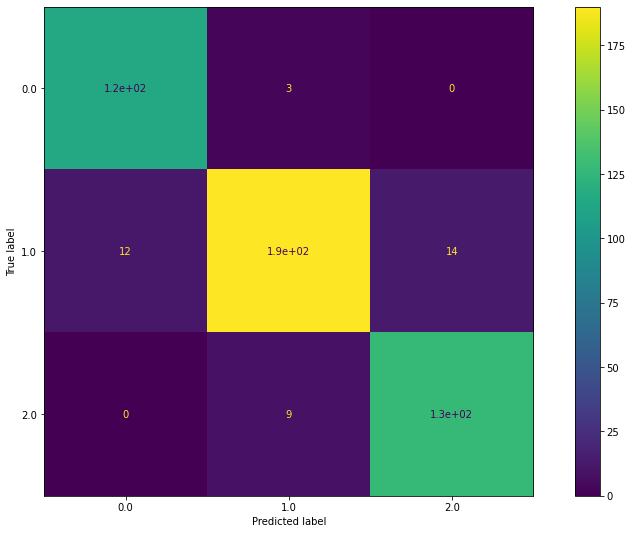

In [126]:
#Séparation des données en données d'entrainement(70%) et de données de test(30%) 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

#Création de la fonction avec Random Forest

clf=RandomForestClassifier(min_samples_leaf = 1, min_samples_split = 2, n_estimators=1500) # n : nombre d'arbres

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

feature_imp = pd.Series(clf.feature_importances_, index = ["MACD",'RSI', 'STO_K', "D", '20d-50d','momentum','capm']).sort_values(ascending=False)

#Matrice de confusion 

metrics.plot_confusion_matrix(clf, X_test, y_test)

No handles with labels found to put in legend.


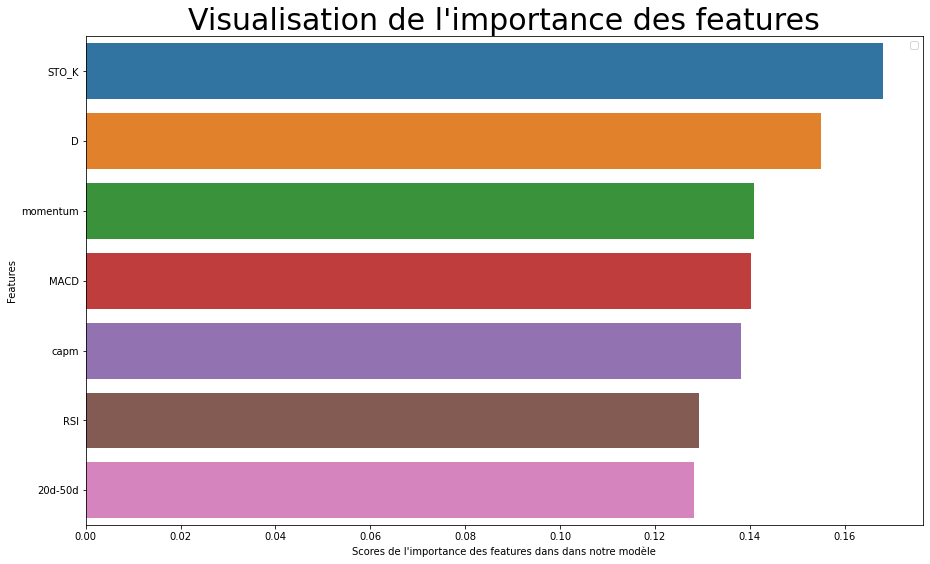

In [127]:
# Mesure l'importance des features avec un histogramme
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel("Scores de l'importance des features dans dans notre modèle")
plt.ylabel('Features')
plt.title("Visualisation de l'importance des features", fontsize=30)
plt.legend()
plt.show()

# Corrélation des actions du portefeuille

$\underline{Idee}$ : Regarder les corrélations des actions du portefeuille en regroupant les actions les plus corrélées dans des familles.

On appliquera le ML sur chaque famille pour tester l'hypothèse suivante : **"l'entrainement de notre modèle sur un ensemble de données cohérentes renvoie un meilleur résultat"**. 

On regarde la matrice de corrélation du cours des actions du CAC40 pour former des familles d'actions corrélées. Cette étape peut aussi être utile pour diversifier son portefeuille et éviter de ne suivre qu'une seule tendance si les actions de cette famille venaient à baisser.

In [128]:
# Création d'un DataFrame avec en colonne les actions du cac40 et avec les indicateurs économiques en ligne.

stocks_cac40 = pd.DataFrame({x : data_cac40[x]["Adj Close"] for x in name_cac40})

In [129]:
#dict_stocks_cac40={"lvmh":lvmh, "danone": danone,"thales": thales,"airbus": airbus,"total": total,"veolia": veolia,"so_ge": societegenerale,"vinci": vinci,"peugeot": peugeot,"capge": capgemini,"axa": axa,"safran": safran,"Airliq": airliquide,"CARF": carrefour,"orange": orange,"accor": accor,"bouygues": bouygues,"WORLDL": worldline,"kering": kering,"engie": engie,"BNP": bnp,"CA": creditagricole,"sanofi": sanofi,"pernod": pernodricard,"schneid": schneiderelectric,"l_oreal": loreal,"michelin": michelin,"vivendi": vivendi,"atos": atos,"sodexo": sodexo,"legrand": legrand,"St_Gob": saintgobain,"arcelor": arcelormittal,"dassault": dassault,"essilor": essilorluxottica,"hermes": hermes,"publicis": publicis,"technip": technipfmc,"unibail": unibail,"renault": renault,"STM": stmicroelectronics}

Text(0.5, 1.05, 'Matrice de corrélation')

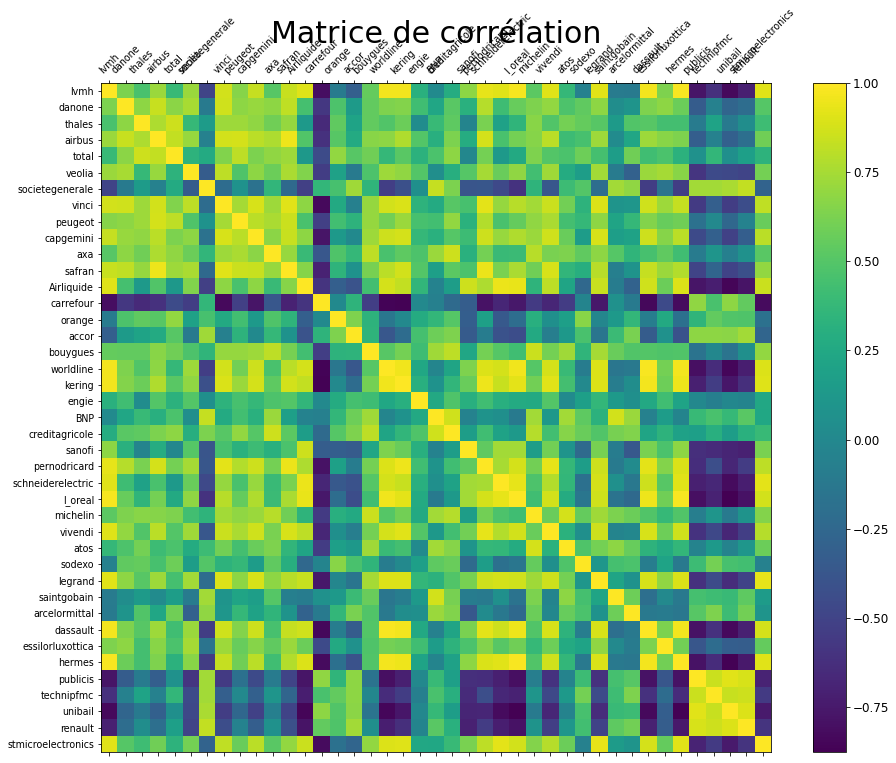

In [130]:
# MATRICE DE CORRELATIONS = HEAT MAP

f = plt.figure(figsize=(15, 12))
plt.matshow(stocks_cac40.corr(), fignum=f.number)
plt.xticks(range(stocks_cac40.shape[1]), stocks_cac40.columns, fontsize=9.5, rotation=45)
plt.yticks(range(stocks_cac40.shape[1]), stocks_cac40.columns, fontsize=9.5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Matrice de corrélation', fontsize=30)

In [131]:
cac ={"lvmh":clf, "danone": clf,"thales": clf,"airbus": clf,"total": clf,"veolia": clf,"so_ge": clf,"vinci": clf,"peugeot": clf,"capge": clf,"axa": clf,"safran": clf,"Airliq": clf,"CARF": clf,"orange": clf,"accor": clf,"bouygues": clf,"WORLDL": clf,"kering": clf,"engie": clf,"BNP": clf,"CA": clf,"sanofi": clf,"pernod": clf,"schneid": clf,"l_oreal": clf,"michelin": clf,"vivendi": clf,"atos": clf,"sodexo": clf,"legrand": clf,"St_Gob": clf,"arcelor": clf,"dassault": clf,"essilor": clf,"hermes": clf,"publicis": clf,"technip": clf,"unibail": clf,"renault": clf,"STM": clf}

## Construction des familles

On va ensuite s'atteler à la création des familles à partir des corrélations que les actions peuvent avoir entre elles.


In [132]:
# On crée deux matrices de corrélation 
# L'une nous sert à sélectionner les différentes actions selon leur corrélation
mat_corr = stocks_cac40.corr().copy()

# L'autre est immuable, et permet de ne sélectionner qu'une seule et unique fois chaque action
mat_corr_immu = stocks_cac40.corr().copy()


# liste qui contiendra les différentes familles
family = [[] for k in range(41)]

# On crée une liste avec le nom des actiosn pour relier un indice à un nom d'action
liste_actions = []
for corr in mat_corr:
  liste_actions.append(corr)
liste_actions

# Compteur pour n'avoir qu'une famille par action
S = 41

# Dictionnaire des indices de la matrice de corrélation immuable qu'on videra au fur et à mesure qu'une action sera choisie  (une liste verrait ses indices modifiés)
liste_index = {k:k for k in range(0,S)}

for num_ligne in range(0,S):
  if not num_ligne in liste_index:
    continue 
  for num_colonne in range(0,S):
    if not num_colonne in liste_index:
      continue
    if abs(mat_corr_immu.iloc[num_ligne, num_colonne]) > 0.8 :
      family[num_ligne].append(liste_actions[num_colonne])
      mat_corr.drop([liste_actions[num_colonne]], axis = 'columns', inplace = True)
      del liste_index[num_colonne]

In [133]:
# Extraction des familles sous forme de DataFrame

family2 = []
for k in range(41):
  if family[k] != []:
    family2.append(family[k])

In [66]:
end2 = datetime.date(2018,10,31)
data = {k:[] for k in range(len(family2))}
X = {k:k for k in range(len(family2))}
Y = {k:k for k in range(len(family2))}

for i in range(len(family2)):
  data[i] = pd.concat([prepare(data_cac40[family2[i][j]] , end=end2) for j in range(len(family2[i]))])
  data[i] = data_augmentation(data[i])
  X[i] = data[i][['MACD', 'RSI', 'STO_K', 'D', '20d-50d', 'momentum','capm']]
  Y[i] = data[i]["Signal"]

## Construction d'un classifieur de *Random Forest* par famille


On peut désormais construire chacun des classifieurs *Random Forest* : 

In [67]:
#Séparation des données en données d'entrainement(70%) et de données de test(30%) 
donnee_test = []
cac2 = cac.copy()
for i in range(len(family2)):
  donnee_test.append(train_test_split(X[i], Y[i], test_size=0.3))

#Création de la fonction avec Random Forest, une par famille
foret_alea = [] #fonction de la famille i à l'indice i
y_pred = []
for i in range(len(family2)):
  clf=RandomForestClassifier(min_samples_leaf = 1, min_samples_split = 2, n_estimators=1500) # n : nombre d'arbres
  clf.fit(donnee_test[i][0],donnee_test[i][2])
  y_pred.append(clf.predict(donnee_test[i][1]))
  # on met à jour le classifier pour les actions correspondantes
  for act in family2[i]:
    cac2[act] = clf

In [68]:
# Exemple pour la famille 1 (indice 0)

print("Accuracy:",metrics.accuracy_score(donnee_test[0][3], y_pred[0]))

feature_imp = pd.Series(cac['lvmh'].feature_importances_, index = ["MACD",'RSI', 'STO_K', "D", '20d-50d', 'momentum','capm']).sort_values(ascending=False)

#Matrice de confusion 

m = metrics.confusion_matrix(donnee_test[0][3], y_pred[0])
print("Matrice de Confusion : \n",m)
#Ligne : y_test   ; Colonne : y_pred

Accuracy: 0.9267492711370262
Matrice de Confusion : 
 [[2177  114   10]
 [ 184 3203  219]
 [  15   61 2249]]


No handles with labels found to put in legend.


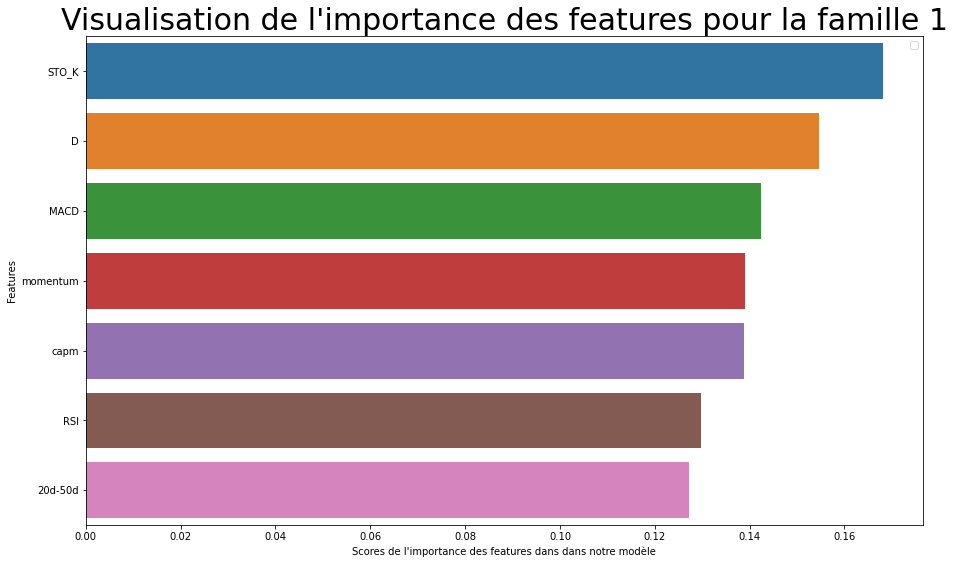

In [69]:
# Mesure l'importance des features avec un histogramme
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel("Scores de l'importance des features dans dans notre modèle")
plt.ylabel('Features')
plt.title("Visualisation de l'importance des features pour la famille 1", fontsize=30)
plt.legend()
plt.show()

Il ne nous reste plus qu'à conserver les classifieurs *Random Forest* dans une table, ce qui nous permettra de les utiliser *a posteriori* afin d'optimiser notre portefeuille d'actions. 

## Présentation des résultats

On a maintenant une fonction issue du ML pour chaque famille d'action. 

Pour une action dans notre portefeuille, on considère la fonction associée à sa famille pour calculer le signal d'achat/vente. 

In [70]:
def ma_crossover_orders(stocks, famille_fonction, start=end2,end=end):
    """
    :param stocks: liste de tuples (symbol, data brute téléchargée de Yahoo)
    :param famille_fonction : Dictionnaire contenant le Classifier de la famille à laquelle appartient l'action en index

    :return: pandas DataFrame contenant les ordres à passer
    """
    
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        s_redim = s[1][start:end].copy()
        clf = famille_fonction[s[0]]
        x = prepare(s_redim,start,end) #50 lignes de moins que s[1][start:end]
        x = x[['MACD', 'RSI', 'STO_K', "D", '20d-50d','momentum','capm']]
        s_redim["Prédiction"] = np.concatenate((50*[-1], clf.predict(x))) #les 50premières dates sont vides à cause de la fct prepare

        signals = pd.concat([
            pd.DataFrame({"Price": s_redim.loc[s_redim["Prédiction"] == 2, "Adj Close"],
                         "Regime": s_redim.loc[s_redim["Prédiction"] == 2, "Prédiction"],
                         "Signal": "Acheter"}),
            pd.DataFrame({"Price": s_redim.loc[s_redim["Prédiction"] == 0, "Adj Close"],
                         "Regime": s_redim.loc[s_redim["Prédiction"] == 0, "Prédiction"],
                         "Signal": "Vendre"}),
        ])

        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)

    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])

    return trades

In [71]:
def backtest(stocks, cash,famille_fonction, portfolio = dict(),port_prices = dict()):
    """
    :param stocks: Une liste de tuples (Symbole de l'action, données brutes de Yahoo)
    :param cash: integer for starting cash value
    :param portfolio: Dictionnaire  nb d'actions détenues à t
    :param port_prices: Dictionnaire prix de l'action à t
    
    :return: pandas DataFrame contenant les ordres à passer

    On se servira dans cette fonction de l'historique de la valeur du portefeuille afin de voir comment il évolue dans le temps. 
    """
    signals = ma_crossover_orders(stocks,famille_fonction)

    # Dataframe qui contiendra les données historiques
    results = pd.DataFrame({"Cash Dispo": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Nb Action": [],
                            "Trade Value": [],
                            "Total Cash": []})

    for index, row in signals.iterrows():

        portfolio_val = 0 
        for key, val in portfolio.items():
            for i,dat in stocks :
               if key ==i:
                  port_prices[key] = dat.loc[str(index[0].date()),"Adj Close"]
            portfolio_val += val * port_prices[key]

        shares = portfolio[index[1]]
        old_price = port_prices[index[1]]
        
        n_max = np.floor((portfolio_val + cash)/(row["Price"]*len(portfolio)))

        if row["Signal"]=="Acheter" and shares<n_max : #la deuxième condition évite d'acheter deux fois consécutives
            trade_val = (n_max-shares)*row["Price"]
            portfolio[index[1]]= n_max
            port_prices[index[1]] = (shares*port_prices[index[1]]+(n_max-shares)*row["Price"])/(n_max)
 
            portfolio_val += trade_val
            cash -= trade_val

            # Update report
            results = results.append(pd.DataFrame({
                    "Cash Dispo":cash,
                    "Portfolio Value": portfolio_val,
                    "Type": row["Signal"],
                    "Nb Action": n_max-shares,
                    "Trade Value": trade_val,
                    "Total Cash": cash +portfolio_val
                }, index = [index]))

        elif row["Signal"]=="Vendre" and shares > 0:
            trade_val = shares * row["Price"]
            portfolio[index[1]]= 0
            port_prices[index[1]] = row["Price"]

            portfolio_val -= trade_val
            cash += trade_val

            # Update report
            results = results.append(pd.DataFrame({
                    "Cash Dispo":cash,
                    "Portfolio Value": portfolio_val,
                    "Type": row["Signal"],
                    "Nb Action": shares,
                    "Trade Value": trade_val,
                    "Total Cash": cash +portfolio_val
                }, index = [index]))

        else : pass 

    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
    return results

stocks = [("lvmh",data_cac40['lvmh']),
        ("danone", data_cac40['danone']),
        ("thales", data_cac40['thales']),
        ("airbus", data_cac40['airbus']),
        ("veolia", data_cac40['veolia']),
        ("vinci", data_cac40['vinci']),
        ("peugeot", data_cac40['peugeot']),
        ("capge", data_cac40['capgemini']),
        ("so_ge", data_cac40['societegenerale']),
        ("safran", data_cac40['safran'])]

portfolio = {"lvmh" : 0, "danone" : 0,"thales":0, "airbus":0,"veolia":0,"vinci":0,"peugeot":0,"capge":0,"so_ge":0,"safran":0}
port_prices = {"lvmh" : 0, "danone" : 0,"thales":0, "airbus":0,"veolia":0,"vinci":0,"peugeot":0,"capge":0,"so_ge":0,"safran":0}

cash = 1000000
bk_ML_cor = backtest(stocks, cash,cac2, portfolio, port_prices)


cash = 1000000
portfolio = {"lvmh" : 0, "danone" : 0,"thales":0, "airbus":0,"veolia":0,"vinci":0,"peugeot":0,"capge":0,"so_ge":0,"safran":0}
port_prices = {"lvmh" : 0, "danone" : 0,"thales":0, "airbus":0,"veolia":0,"vinci":0,"peugeot":0,"capge":0,"so_ge":0,"safran":0}

bk_ML = backtest(stocks, cash,cac, portfolio, port_prices)


bk_ML_cor.head()

KeyboardInterrupt: ignored

## Graphique des performances

In [ ]:
d = pd.Timedelta('1 day')
cac40 = pdr.get_data_yahoo('^FCHI', start=end3+25*d, end=end)


bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot(grid=True,label = "Trend Following")

bk_sto["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot(grid=True, label = "Stochastique")

bk_ML["Total Cash"].groupby(level = 0).apply(lambda x: x[-1]).plot(grid=True,label = "ML")

bk_ML_cor["Total Cash"].groupby(level = 0).apply(lambda x: x[-1]).plot(grid=True,label = "ML & Corrélation")

plt.legend()
plt.title('Graphique des performances', fontsize = 20)

Ce graphique résume l'ensemble de nos résultats. On affiche nos résultats : l'évolution d'un portefeuille dirigé par le trend following (méthode naïve), le classifieur sans corrélation et ensuite la méthode avec la corrélation. 

La méthode des classifieurs n'est pas une méthode déterministe, ce qui conduit à une variation des résultats. Néanmoins, il en ressort tout le temps la même finalité : la méthode avec le trend following comme seul indicateur est toujours moins bonne que celle qui combine tous les indicateurs avec le classifieur. Le fait de créer des classifieurs par familles de corrélation permet d'obtenir de meilleurs résultats qu'avec un classifier seul (ce résultat peut ne pas être perçu sur un graphique du fait que ce modèle est non déterministe). 

# Conclusion

## Résultats et regard critique

Notre avons donc tester la fiabilité de notre modèle pour évaluer sa pertinence.

Ce projet nous a permis de nous familiariser avec les libraires Numpy, Pandas et Scikit-Learn. Il nous a également permis de découvrir des indicateurs utilisés dans le domaine de la finance pour donner du sens au cours des actions et aider dans la prise de décision. Nous avons ainsi pu voir une application concrète de différentes stratégies de trading en se basant sur ces indicateurs. 

In fine, ce projet nous a fait gagner en autonomie vis-à-vis de l'élaboration d'un code. Il nous a également permis de travailler en équipe et de confronter nos idées pour faire avancer le projet.

En outre, l'ajout des corrélations des actions dans notre programme est un véritable atout pour la diversification d'un portefeuille. L'exemple présenté s'étend à toute action qui a fait l'objet d'une même préparation. L'avantage d'avoir utilisé le Random Forest et pas un autre algorithme est le fait que ces résultats sont interprétables. En combinant les conditions aux noeuds de tous les arbres conçus, on est en mesure d'interpréter les résultats fournis. C'est un plus en finance parce que légalement on a la capacité de justifier les investissements en cas de perte d'argent.